In [503]:
import pandas as pd
import nibabel as nib
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('..')
import sfp 
import math
from scipy import stats
from scipy import optimize as opt
import torch
import glob
import os
import warnings
import itertools
import altair as alt
import hessian
from torch.utils import data as torchdata

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
sns.set_style('whitegrid')
df_path = "/mnt/winawerlab/Projects/spatial_frequency_preferences/BIDS/derivatives/first_level_analysis/stim_class/posterior/sub-wlsubj045/ses-04/sub-wlsubj045_ses-04_task-sfprescaled_v1_e1-12_summary.csv"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Model motivation

To explain the motivation behind this model, let's step through some reasoning.

In [8]:
# Load in data
df = pd.read_csv(df_path)

Let's look at some voxels that have good GLM $R^2$ values and pick one

In [12]:
df[(df.varea==1)&(df.R2>40)].drop_duplicates('voxel').sort_values('R2', ascending=False).head(20)[['voxel', 'R2', 'varea', 'hemi', 'angle' ,'eccen', 'precision']]

voxel         R2  varea hemi     angle     eccen  precision
2811   2811  46.440060      1   rh  1.570793  2.088507   5.460466
2812   2812  44.630062      1   rh  1.574770  2.106033   4.484139
2805   2805  44.474243      1   rh  1.602626  2.028465   4.590699
2818   2818  44.376331      1   rh  1.571172  2.071329   5.733254
2817   2817  43.290607      1   rh  1.578023  1.975799   7.439803
2804   2804  43.142612      1   rh  1.591477  1.997247   5.161090
2819   2819  41.135906      1   rh  1.632733  2.116547   6.454978
1961   1961  40.302860      1   lh  4.735274  2.738998   2.115435

In [13]:
# Pick a V1 voxel with a good R2
voxel_df = df[(df.voxel.isin([2811]))]#, 1421]))]
voxel_df.head()

varea  voxel stimulus_superclass  w_r   w_a     eccen     angle  \
2811       1   2811             angular  0.0   6.0  2.088507  1.570793   
8489       1   2811             angular  0.0   8.0  2.088507  1.570793   
14167      1   2811             angular  0.0  11.0  2.088507  1.570793   
19845      1   2811             angular  0.0  16.0  2.088507  1.570793   
25523      1   2811             angular  0.0  23.0  2.088507  1.570793   

       stimulus_class  amplitude_estimate_std_error hemi  \
2811                0                      0.398486   rh   
8489                1                      0.374436   rh   
14167               2                      0.472738   rh   
19845               3                      0.447664   rh   
25523               4                      0.474922   rh   

                      ...                      local_w_r  local_w_a  \
2811                  ...                   2.799731e-17   0.457231   
8489                  ...                   3.732974e-17   0.609641   
14167                 ...                   5.132840e-17   0.838256   
19845                 ...                   7.465949e-17   1.219282   
25523                 ...                   1.073230e-16   1.752718   

       local_sf_magnitude  local_sf_xy_direction  local_sf_ra_direction  \
2811             0.457231               3.141589               1.570796   
8489             0.609641               3.141589               1.570796   
14167            0.838256               3.141589               1.570796   
19845            1.219282               3.141589               1.570796   
25523            1.752718               3.141589               1.570796   

       baseline  precision  amplitude_estimate_norm  \
2811          0   5.460466                28.254143   
8489          0   5.460466                28.254143   
14167         0   5.460466                28.254143   
19845         0   5.460466                28.254143   
25523         0   5.460466                28.254143   

       amplitude_estimate_median_normed  amplitude_estimate_std_error_normed  
2811                           0.105021                             0.014104  
8489                           0.124197                             0.013252  
14167                          0.159354                             0.016732  
19845                          0.176313                             0.015844  
25523                          0.214248                             0.016809  

[5 rows x 31 columns]

In [14]:
sns.set_context('notebook')
sns.set_style('white')

In [15]:
pal = sns.palettes.color_palette('deep', 5)
pal = {'radial': pal[0], 'reverse spiral': pal[4], 'forward spiral': pal[2], 'angular': pal[3], 'mixtures': pal[1]}
hue_order = ['radial', 'reverse spiral', 'forward spiral', 'angular', 'mixtures']

Let's examine the response of this voxel as a function of spatial frequency. In the plot below, we plot the normed amplitude estimate as a function of the local spatial frequency. We see that the response looks roughly log-Normal, but there appears to be some difference between the different stimulus classes.

/home/billbrod/miniconda3/envs/sfp/lib/python3.6/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


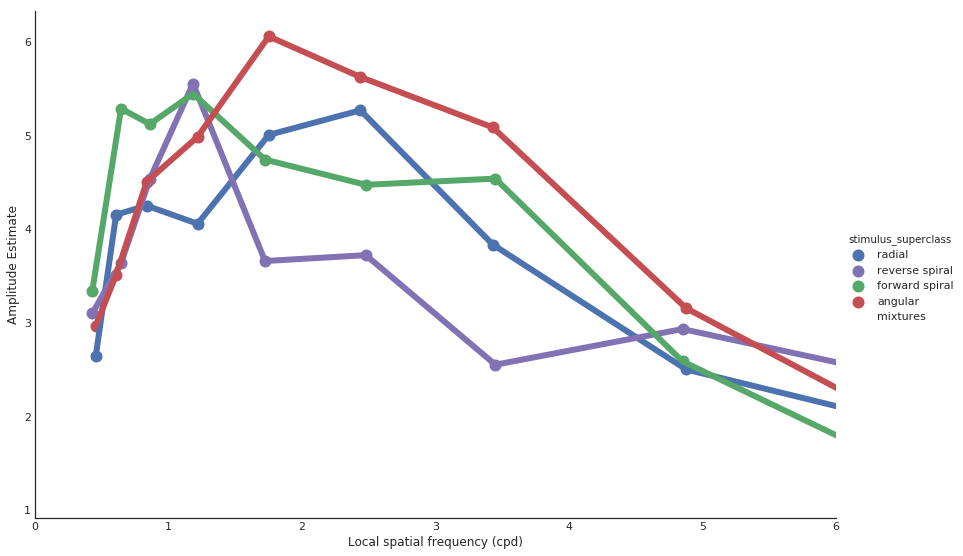

In [16]:
g = sns.FacetGrid(voxel_df[~voxel_df.stimulus_superclass.isin(['mixtures'])], hue='stimulus_superclass',palette=pal, size=8, aspect=1.5, hue_order=hue_order)
g.map(plt.scatter, 'local_sf_magnitude', 'amplitude_estimate_median', linewidth=6)
g.map(plt.plot, 'local_sf_magnitude', 'amplitude_estimate_median', linewidth=6)
# g.ax.set_xscale('log', basex=2)
g.add_legend()
g.ax.tick_params(size=0)
g.ax.set_xlim((0, 6))
g.set_xlabels('Local spatial frequency (cpd)')
g.set_ylabels('Amplitude Estimate')

These classes differ in their local orientation, so we can look at a plot of the response as a function of the local spatial frequency with respect to x and y (size represents the response). This plot is difficult to parse, but the main point is that these different stimulus classes are not arbitrary and discrete: they lie on a continuum, related by the stimulus orientation, and so we can fit the response of the voxel as a 2d tuning curve.

/home/billbrod/miniconda3/envs/sfp/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/home/billbrod/miniconda3/envs/sfp/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
/home/billbrod/miniconda3/envs/sfp/lib/python3.6/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, U

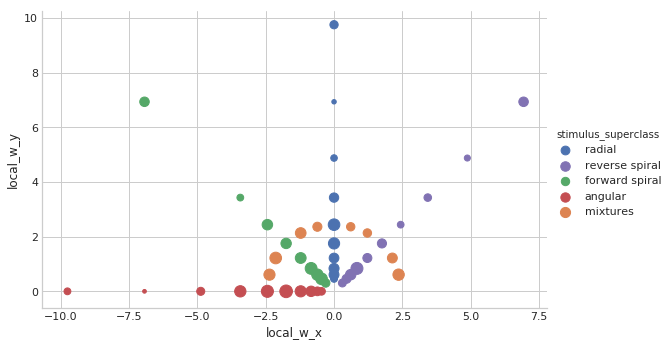

In [17]:
def scatter_sizes(x, y, s, plot_color=False, cmap=None, size_scale=1, **kwargs):
    if plot_color:
        kwargs.pop('color')
        if cmap is None:
            cmap = 'Blues'
        plt.scatter(x, y, s=s*80*size_scale, c=s, cmap=cmap, **kwargs)
    else:
        plt.scatter(x, y, s=s*80*size_scale, **kwargs)

with sns.axes_style('whitegrid'):
    voxel_df['normalized_resp'] = voxel_df['amplitude_estimate_median'].copy()
    voxel_df['normalized_resp'] = (voxel_df['normalized_resp'] - voxel_df['normalized_resp'].min()) / (voxel_df['normalized_resp'].max() - voxel_df['normalized_resp'].min())
    g=sns.FacetGrid(voxel_df, size=8, aspect=1, hue='stimulus_superclass', palette=pal, hue_order=hue_order)
    g.map(scatter_sizes, 'local_w_x', 'local_w_y', 'normalized_resp', plot_color=False, size_scale=2)
    g.add_legend()
    scatter_ax = plt.gca()
    scatter_ax.set_aspect('equal')
    g.ax.tick_params(size=0)

This is just that same data, but rotated and plotted on a semi-log plots.

/home/billbrod/miniconda3/envs/sfp/lib/python3.6/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


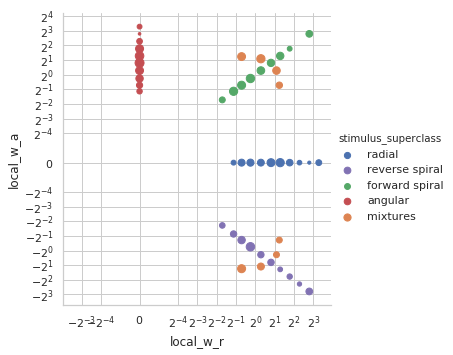

In [18]:
with sns.axes_style('whitegrid'), sns.plotting_context('notebook'):
    g=sns.FacetGrid(voxel_df, hue='stimulus_superclass', size=5, aspect=1, palette=pal, hue_order=hue_order)
    g.map(scatter_sizes, 'local_w_r', 'local_w_a', 'normalized_resp')
    g.add_legend()
    scatter_ax = plt.gca()
    scatter_ax.set_xscale('symlog', basex=2, linthreshx=2**(-4))
    scatter_ax.set_yscale('symlog', basey=2, linthreshy=2**(-4))

But then the question is: how does the tuning change with orientation? Two possibilities are:

1. The preferred frequency of the tuning curve / mode of the log-Gaussian distribution changes with orientation.
2. The amplitude of the tuning curve changes with orientation.

Then there's the question of how either the mode or the amplitude changes with orientation. Let's assume it changes smoothly and periodically, symmetrically about 180 degrees (because 2d orientation is runs from 0 to 180 degrees). We'll examine three possibilities in the plots below, from left to right:

1. all orientation are equally important (mode/amplitude does not depend on orientation; constant)
2. horizontal or vertical is preferred, but the other is anti-preferred (sinusoid with frequency $2\theta$)
3. the cardinals are preferred, the obliques are anti-preferred (sinusoid with frequency $4\theta$)

The following plots show these three possibilities, with the top showing a plot of orientation vs mode/response, while the bottom shows this on an x/y plot: the line represents either the mode or the level set of the max amplitude.

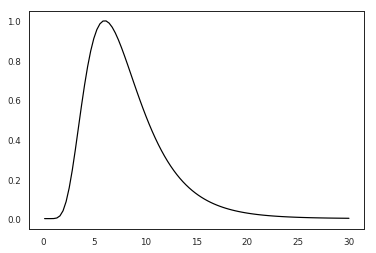

In [19]:
with sns.plotting_context('paper'), sns.axes_style('white'):
    x = np.linspace(.1, 30, 100)
    y = sfp.tuning_curves.log_norm_pdf(x,1, 6, .45)
    plt.plot(x, y, 'k')

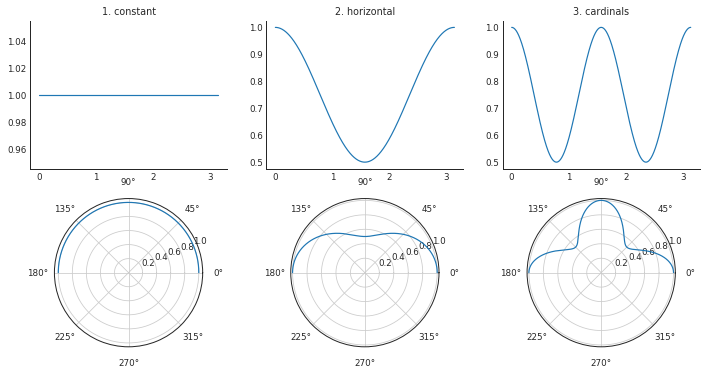

In [20]:
with sns.plotting_context('paper'):
    fig = plt.figure(figsize=(12,6))
    theta = np.linspace(0, np.pi, 1000)
    for i, f, title in zip(range(3), [0, 2, 4], ['1. constant', '2. horizontal', '3. cardinals']):
        r = (np.cos(f*theta) + 3) / 4
        ax = plt.subplot(2,3,i+1)
        ax.plot(theta, r)
        ax.tick_params(size=0)
        sns.despine(ax=ax)
        ax.set_title(title)
        ax = plt.subplot(2,3,4+i, projection='polar')
        ax.plot(theta, r)

Okay so then how do we set up the function that we're going to fit? First, let's look at the 1d log-Normal distribution we used before. Normally, this distribution is parameterized by $\mu$ and $\sigma^2$. These are *not* the mean and variance, the way they are for the regular Normal distribution. We'll keep using $\sigma^2$ but we'll use the mode, $M$ instead of $\mu$: $M = \exp(\mu - \sigma^2) \Rightarrow \mu = \ln(M) + \sigma^2$.

Thus, when we're modeling the response, $R$ as a 1d log-Normal tuning curve with respect to the spatial frequency $\omega$, it's: $R=A * \exp(-\frac{(\ln(\omega)-\ln(M)-\sigma^2)^2}{2\sigma^2})$.

Now we're extending this to make it 2d, as a funtion of spatial frequency $\omega$ and orientation $\theta$. To allow for the amplitude varying with orientation, we expand upon $A$ and make it orientation-dependent: $A_0 + A_1\cos2\theta + A_2\cos4\theta$. To allow the mode to vary, we make similarly make $M$ orientation-dependent: $M_0 + M_1\cos2\theta + M_2\cos4\theta$.

Putting it altogether we get:

$(A_0 + A_1\cos2\theta + A_2\cos4\theta)\exp(-\frac{(\ln(\omega)-\ln(M_0 + M_1\cos2\theta + M_2\cos4\theta)-\sigma^2)^2}{2\sigma^2})$

which gives us 7 parameters to fit: $A_0, A_1, A_2, M_0, M_1, M_2, \sigma$

Let's look at some examples of this function, to get a sense of its expressive power.

In [21]:
omega = np.logspace(-3, 3, 100, base=2)
theta = np.linspace(0, 2*np.pi, 100)

def log_norm_2d(omega, theta, A0=1, A1=0, A2=0, M0=1, M1=0, M2=0, sigma=1):
    omega = np.array(omega)
    theta = np.array(theta)
    amp = A0 + A1*np.cos(2*theta) + A2*np.cos(4*theta)
    mode = M0 + M1*np.cos(2*theta) + M2*np.cos(4*theta)
    #pdf = (1/(omega*sigma*np.sqrt(2*np.pi))) * np.exp(-(np.log(omega)-mu)**2/(2*sigma**2))
    #pdf /= pdf.max()
    pdf = sfp.tuning_curves.log_norm_pdf(omega, amp, mode, sigma)
    return pdf

omega, theta = np.meshgrid(omega, theta)

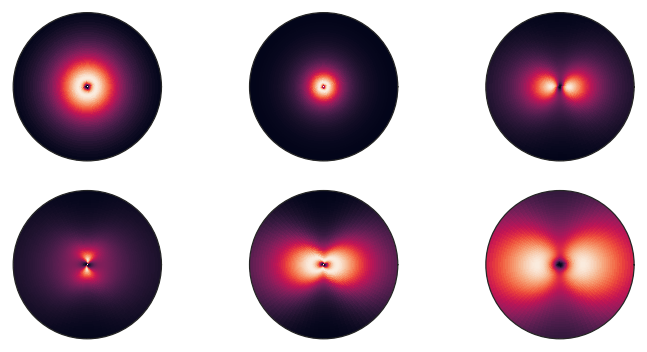

In [22]:
fig, axes = plt.subplots(2, 3, subplot_kw={'projection': 'polar'}, figsize=(12, 6))

params = [{}, {'M0': .5}, {'A1': .5}, {'M1': .5}, {'A1': .5, 'M1': .5, 'M0': 1}, {'A1': .5, 'M1': .5, 'M0':2}]

with sns.plotting_context('notebook'):
    for i, ax in enumerate(axes.flatten()):
        R = log_norm_2d(omega, theta, **params[i])
        ax.pcolormesh(theta, omega, R)
        ax.set_xticks([])
        ax.set_rticks([])

This is on a voxel-by-voxel basis, but what about across the whole area? To extend it to all of V1, let's consider two frames of reference: fixed and relative.

In the fixed frame, all voxels have the same tuning. Orientation, $\theta_f$, above refers to Cartesian, world-relate orientation so that $\theta_f=0$ corresponds to "to the right". Spatial frequency, $\omega_f$, means the local spatial frequency in the image. This encodes our "constant" extreme possibility from earlier.

In the relative frame, voxel tuning depends on its location in the retinotopic map. We remap orientation and spatial frequency so that $\theta_r=0$ corresponds to "away from the fovea" and spatial frequency is scaled by eccentricity: $\omega_r=\omega_f(e+b)$, where $e$ is the eccentricity of the voxel's pRF and $b$ is some constant.

We then sum these two versions of the model so that we have a 15-parameter model (two versions of the 7 parameters above, plus $b$) that we fit simultaneously to all of V1.

# Voxel precision

One of the things we care about is the noisiness of our voxels. We'll use this in our loss function, so we want to know whether we can calculate the noise on a voxel-by-voxel basis or whether we have to worry about differing levels of noise for different stimulus classes.

In [63]:
df = pd.read_csv(df_path)

What's unclear from the following plot is whether the apparent relationship between the median amplitude estimate and the error is because of differences *between* voxels or *within* them. If it's between voxels, we're fine, but it's bad if it's within them (this would be like for a Poisson-process neuron, whose variance increases with the mean firing rate)

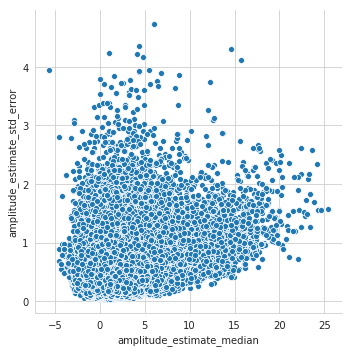

In [5]:
sns.relplot(x='amplitude_estimate_median', y='amplitude_estimate_std_error', data=df)

So to answer this question, we do a simple linear regression between the median amplitude estimate and the standard error.

In [30]:
def linear_regression(data, x='amplitude_estimate_median', y='amplitude_estimate_std_error'):
    s,i,r,p,e = stats.linregress(data[x], data[y])
    return pd.Series({'slope': s, 'intercept': i, 'r_squared': r**2, 'p_value': p, 'stderr': e})

linregress = df.groupby('voxel').apply(linear_regression)

And what we see here is that there doesn't appear to be a consistent relationship between the median amplitude estimate and the error of those estimates: the slope looks like it's distributed around zero, as does the relationship between slope and intercept. This is good, so we can treat precision as a voxel-by-voxel number

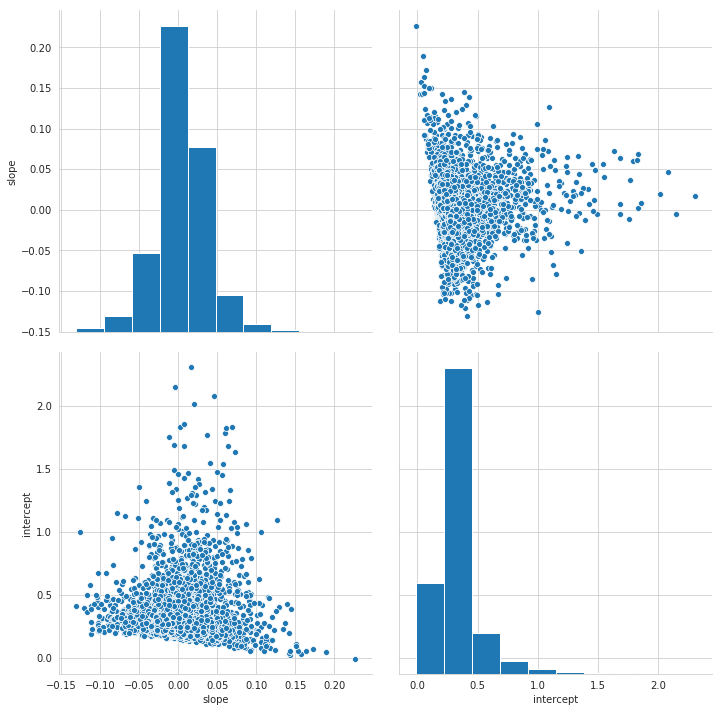

In [35]:
sns.pairplot(linregress, vars=['slope', 'intercept'], height=5)

# Torch

Model is:

$\exp{\frac{-(\log_2(\omega) + \log_2(ae+b))^2}{2 \sigma^2}}$

In [77]:
a = 1
b = 0
model = sfp.model.LogGaussianDonut(sf_ecc_slope=a, sf_ecc_intercept=b)
model.eval()

LogGaussianDonut(sigma: 0.400, sf_ecc_slope: 1.000, sf_ecc_intercept: 0.000, abs_amplitude_cardinals: 0.000, abs_amplitude_obliques: 0.000, abs_mode_cardinals: 0.000, abs_mode_obliques: 0.000, rel_amplitude_cardinals: 0.000, rel_amplitude_obliques: 0.000, rel_mode_cardinals: 0.000, rel_mode_obliques: 0.000)

When we build the model like this, we see it has a number of desirable features (note that for this version, there is no effect of orientation or retinal angle, so a single 1d tuning curve at each eccentricity completely characterizes the response of a voxel there). The following plots the responses on a log (left) and linear (right) x axis, for the perfectly scaling model at four different (log-spaced) eccentricities. We see that the tuning curve is log-normal, response peaks at 1, that the spatial frequency that drives the maximum response doubles as the eccentricity halves, and that the standard deviation is 1 octave (thus, the width of the tuning curve is constant in log space, but increases with the mode in linear space).

[(0, 10), Text(0.5,0,'spatial frequency (linear scale)')]

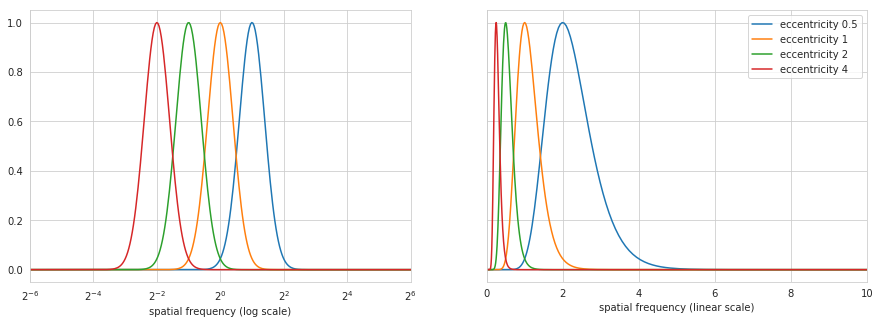

In [8]:
x = np.logspace(-6, 5, 1000)
es = [.5, 1, 2, 4]
fig, axes = plt.subplots(1,2, sharey='all', figsize=(15,5))
for e in es:
    # with this parameterization, orientation and retinal angle don't matter, so we just make them 0s
    r = model.forward(x, np.zeros_like(x), e*np.ones_like(x), np.zeros_like(x)).detach().numpy()
    axes[0].semilogx(x, r, label='eccentricity %s'%e, basex=2)
    axes[1].plot(x, r, label='eccentricity %s'%e)
    plt.legend()
axes[0].set(xlim=(2**-6, 2**6), xlabel='spatial frequency (log scale)')
axes[1].set(xlim=(0, 10), xlabel='spatial frequency (linear scale)')

We can see what this looks like a little better by plotting the response as a heatmap, with eccentricity on the x-axis and period (the reciprocal of the spatial frequency) on the y-axis. (We plot against the period because then this will be linear, rather than hyperbolic.) The solid line here shows the (analytic) mode of the responses, while the dashed lines show one standard deviation above and below

In [10]:
eccen = np.linspace(0.01, 12, 120)
period = np.linspace(.01, eccen.max()*a+b, 100)
resps = np.zeros((100, 120))
for i, e in enumerate(eccen):
    r = model.evaluate(1./period, np.zeros_like(period), e*np.ones_like(period), np.zeros_like(period)).detach()
    resps[:,i] = r

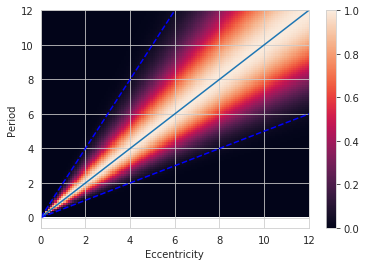

In [11]:
ax = plt.imshow(resps, origin='lower', extent=(eccen.min(), eccen.max(), period.min(), period.max()), aspect='auto')
plt.ylabel('Period')
plt.xlabel('Eccentricity')
plt.plot(eccen,(a*eccen+b))
plt.plot(eccen,(a/2.*eccen+b), 'b--')
y = a*2*eccen+b
plt.plot(eccen[y<period.max()],y[y<period.max()], 'b--')
plt.colorbar()

Clean this up and explain it

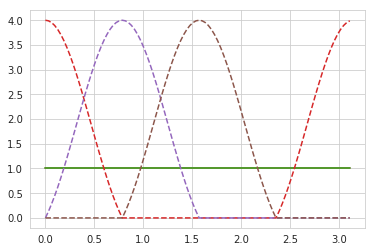

In [13]:
theta = np.linspace(0, np.pi, 100, endpoint=False)
model = sfp.model.LogGaussianDonut('relative', sigma=1, sf_ecc_slope=1, rel_mode_cardinals=0, rel_amplitude_cardinals=2, rel_amplitude_obliques=1)
plt.plot(theta, model.preferred_period(theta, 1, [0, np.pi/4, np.pi/2]).detach().numpy().T)
plt.plot(theta, model.max_amplitude(theta, [0, np.pi/4, np.pi/2]).detach().numpy().T, '--')
#model.preferred_period(theta, [1,2], 0)

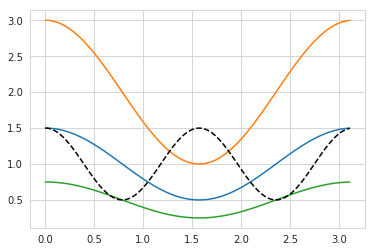

In [13]:
theta = np.linspace(0, np.pi, 100, endpoint=False)
model = sfp.model.LogGaussianDonut('relative', sigma=1, sf_ecc_slope=1, rel_mode_cardinals=.5, rel_amplitude_obliques=.5)
plt.plot(theta, model.preferred_period(theta, [1,2, .5], 0).detach().numpy().T)
plt.plot(theta, model.max_amplitude(theta, 0).detach().numpy(),'k--')
#model.preferred_period(theta, [1,2], 0)

[(0.015625, 32)]

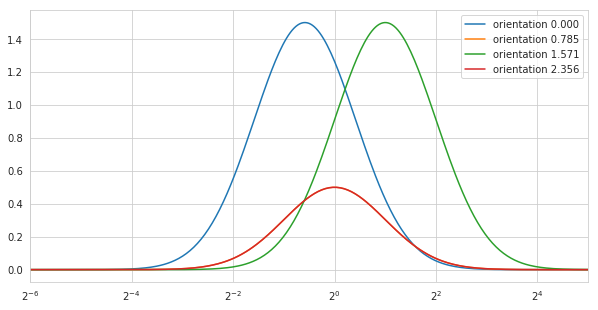

In [14]:
x = np.logspace(-6, 5, 1000)
e = 1
fig, axes = plt.subplots(1,1, True,True, figsize=(10,5))
theta = [0, np.pi/4, np.pi/2, 3*np.pi/4]
for i, a in enumerate(theta):
    r = model.forward(x, a*np.ones_like(x), e*np.ones_like(x), np.zeros_like(x)).detach().numpy()
    axes.semilogx(x, r, basex=2, label='orientation %.03f' % a,)
plt.legend()
axes.set(xlim=(2**-6, 2**5))

In [9]:
autoreload.reload(sfp.model)

<module 'sfp.model' from '../sfp/model.py'>

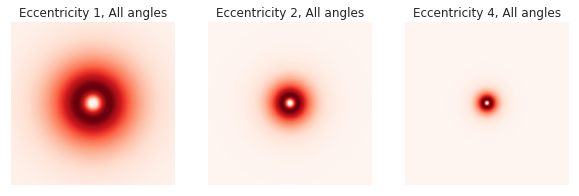

In [11]:
model = sfp.model.LogGaussianDonut(sigma=1)

eccens = [1,2,4]
angles = [0]
fig, axes = plt.subplots(len(angles), len(eccens), True, True, figsize=(10,3))
for (a, e), ax in zip(itertools.product(angles, eccens), axes.flatten()):
    sfp.model.show_image(model, e, a, show_colorbar=False, ax=ax)
    ax.set_title("Eccentricity %s, All angles" % (e))
# fig.savefig('iso.svg')

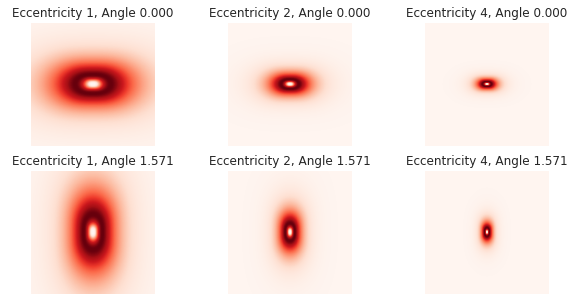

In [12]:
model = sfp.model.LogGaussianDonut('relative', sigma=1, rel_mode_cardinals=.3)

eccens = [1,2,4]
angles = [0, np.pi/2]
fig, axes = plt.subplots(len(angles), len(eccens), True, True, figsize=(10,5))
for (a, e), ax in zip(itertools.product(angles, eccens), axes.flatten()):
    sfp.model.show_image(model, e, a, show_colorbar=False, ax=ax)
    ax.set_title("Eccentricity %s, Angle %.03f" % (e,a))
# fig.savefig('rel.svg')

[(0.015625, 32)]

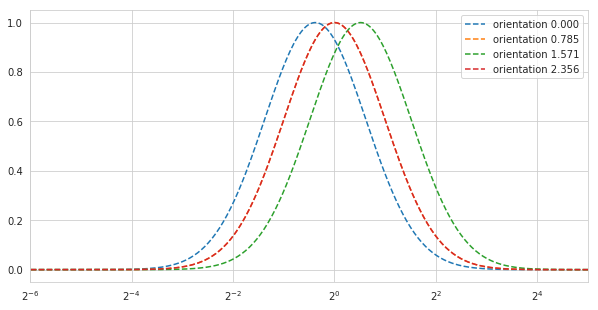

In [13]:
x = np.logspace(-6, 5, 1000)
angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]
e = 1
fig, axes = plt.subplots(1,1, True,True, figsize=(10,5))
for i, a in enumerate(angles):
    r = model.forward(x, a*np.ones_like(x), e*np.ones_like(x), np.zeros_like(x)).detach().numpy()
    axes.semilogx(x, r,'--', basex=2, label='orientation %.03f' % a,)
plt.legend()
axes.set(xlim=(2**-6, 2**5))

Here's an example really complicated model. These parameter values are all very small, so I'm not sure they can be fit, but I'm checking here that we don't get weird things like preferred period or max amplitude hitting 0.

In [335]:
m = sfp.model.LogGaussianDonut('full', 'full', True, 1, .75, .25, .1, .05, .03, .1, .2, .05, .04, .3)

In [344]:
features = sfp.analyze_model.create_feature_df([m], orientation_n_steps=48, retinotopic_angle_n_steps=48)
example_oris = np.linspace(0, np.pi, num=4, endpoint=False)

/home/billbrod/miniconda3/envs/sfp/lib/python3.6/site-packages/matplotlib/tight_layout.py:231: UserWarning: tight_layout : falling back to Agg renderer
  warnings.warn("tight_layout : falling back to Agg renderer")


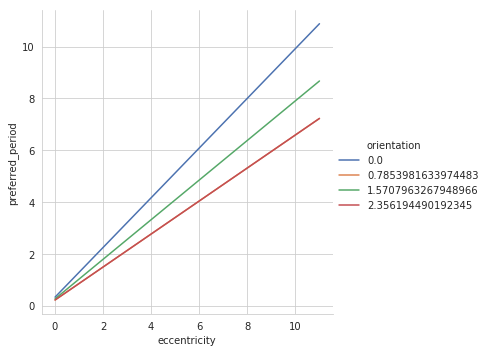

In [347]:
sns.relplot('eccentricity', 'preferred_period', 'orientation', data=features[(features.retinotopic_angle==0)&(features.orientation.isin(example_oris))], palette=sns.color_palette('deep', 4), kind='line')

/home/billbrod/miniconda3/envs/sfp/lib/python3.6/site-packages/matplotlib/tight_layout.py:231: UserWarning: tight_layout : falling back to Agg renderer
  warnings.warn("tight_layout : falling back to Agg renderer")


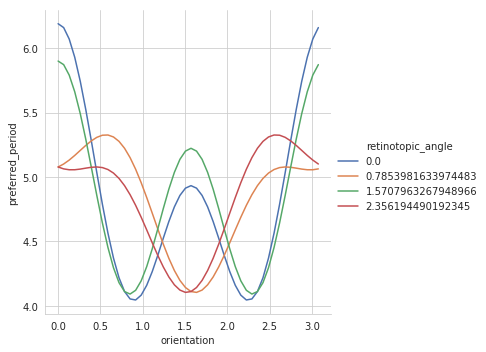

In [357]:
sns.relplot('orientation', 'preferred_period', 'retinotopic_angle', data=features[(features.eccentricity==features.eccentricity.unique()[5])&(features.retinotopic_angle.isin(example_oris))], palette=sns.color_palette('deep', 4), kind='line')

/home/billbrod/miniconda3/envs/sfp/lib/python3.6/site-packages/matplotlib/tight_layout.py:231: UserWarning: tight_layout : falling back to Agg renderer
  warnings.warn("tight_layout : falling back to Agg renderer")


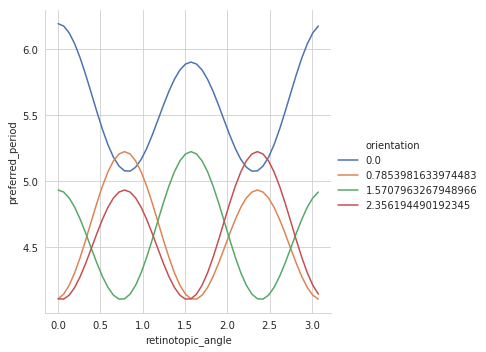

In [350]:
sns.relplot('retinotopic_angle', 'preferred_period', 'orientation', data=features[(features.eccentricity==features.eccentricity.unique()[5])&(features.orientation.isin(example_oris))], palette=sns.color_palette('deep', 4), kind='line')

/home/billbrod/miniconda3/envs/sfp/lib/python3.6/site-packages/matplotlib/tight_layout.py:231: UserWarning: tight_layout : falling back to Agg renderer
  warnings.warn("tight_layout : falling back to Agg renderer")


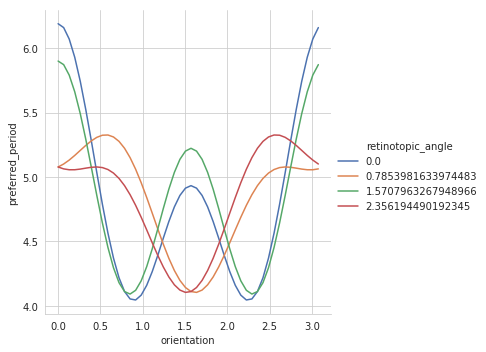

In [351]:
sns.relplot('orientation', 'preferred_period', 'retinotopic_angle', data=features[(features.eccentricity==features.eccentricity.unique()[5])&(features.retinotopic_angle.isin(example_oris))], palette=sns.color_palette('deep', 4), kind='line')

/home/billbrod/miniconda3/envs/sfp/lib/python3.6/site-packages/matplotlib/tight_layout.py:231: UserWarning: tight_layout : falling back to Agg renderer
  warnings.warn("tight_layout : falling back to Agg renderer")


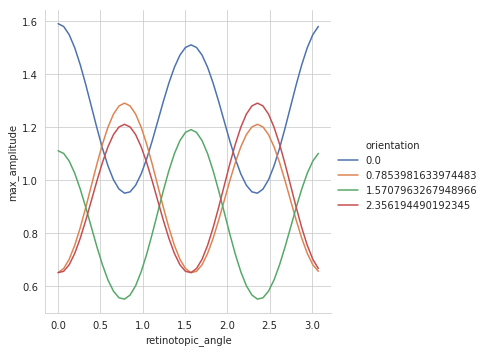

In [354]:
sns.relplot('retinotopic_angle', 'max_amplitude', 'orientation', data=features[(features.eccentricity==features.eccentricity.unique()[5])&(features.orientation.isin(example_oris))], palette=sns.color_palette('deep', 4), kind='line')

/home/billbrod/miniconda3/envs/sfp/lib/python3.6/site-packages/matplotlib/tight_layout.py:231: UserWarning: tight_layout : falling back to Agg renderer
  warnings.warn("tight_layout : falling back to Agg renderer")


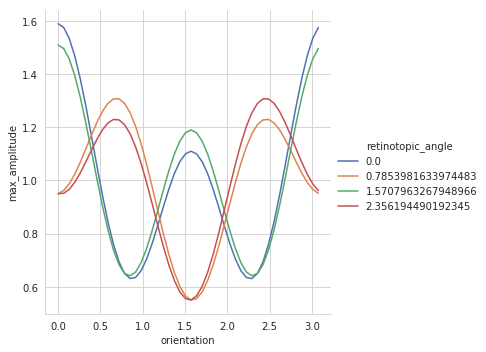

In [353]:
sns.relplot('orientation', 'max_amplitude', 'retinotopic_angle', data=features[(features.eccentricity==features.eccentricity.unique()[5])&(features.retinotopic_angle.isin(example_oris))], palette=sns.color_palette('deep', 4), kind='line')

# Run some things 

In [501]:
s = sfp.simulate_data.main('absolute', 'full', True, 1, .5, .5, save_path='tmp.csv', noise_source_path=df_path, noise_level=1)# abs_amplitude_cardinals=2, abs_amplitude_obliques=1, )
m,l,r,h = sfp.model.main('iso', 'full', False, 'tmp.csv', 
                         batch_size=10, learning_rate=1e-2, max_epochs=100, test_set_stimulus_class=None)

../sfp/model.py:153: UserWarning: When orientation_type is iso, all absolute variables must be 0, correcting this...
  " be 0, correcting this..." % orientation_type)
../sfp/model.py:153: UserWarning: When orientation_type is iso, all absolute variables must be 0, correcting this...
  " be 0, correcting this..." % orientation_type)
../sfp/model.py:153: UserWarning: When orientation_type is iso, all absolute variables must be 0, correcting this...
  " be 0, correcting this..." % orientation_type)
../sfp/model.py:153: UserWarning: When orientation_type is iso, all absolute variables must be 0, correcting this...
  " be 0, correcting this..." % orientation_type)
../sfp/model.py:161: UserWarning: When orientation_type is iso, all relative variables must be 0, correcting this...
  " be 0, correcting this..." % orientation_type)
../sfp/model.py:161: UserWarning: When orientation_type is iso, all relative variables must be 0, correcting this...
  " be 0, correcting this..." % orientation_type

Beginning training!
Average loss on epoch 0: 0.3991996288299561
LogGaussianDonut(sigma: 0.644, sf_ecc_slope: 0.528, sf_ecc_intercept: 0.289, abs_amplitude_cardinals: 0.000, abs_amplitude_obliques: 0.000, abs_mode_cardinals: 0.000, abs_mode_obliques: 0.000, rel_amplitude_cardinals: 0.000, rel_amplitude_obliques: 0.000, rel_mode_cardinals: 0.000, rel_mode_obliques: 0.000)
Average loss on epoch 1: 0.23453368097543717
LogGaussianDonut(sigma: 0.733, sf_ecc_slope: 0.499, sf_ecc_intercept: 0.299, abs_amplitude_cardinals: 0.000, abs_amplitude_obliques: 0.000, abs_mode_cardinals: 0.000, abs_mode_obliques: 0.000, rel_amplitude_cardinals: 0.000, rel_amplitude_obliques: 0.000, rel_mode_cardinals: 0.000, rel_mode_obliques: 0.000)
Average loss on epoch 2: 0.14410332813858986
LogGaussianDonut(sigma: 0.806, sf_ecc_slope: 0.484, sf_ecc_intercept: 0.315, abs_amplitude_cardinals: 0.000, abs_amplitude_obliques: 0.000, abs_mode_cardinals: 0.000, abs_mode_obliques: 0.000, rel_amplitude_cardinals: 0.000, rel

/home/billbrod/miniconda3/envs/sfp/lib/python3.6/site-packages/matplotlib/tight_layout.py:231: UserWarning: tight_layout : falling back to Agg renderer
  warnings.warn("tight_layout : falling back to Agg renderer")


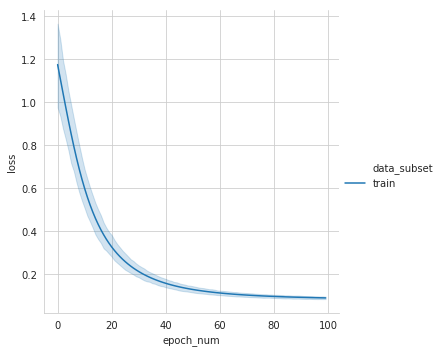

In [498]:
sns.relplot('epoch_num', 'loss', 'data_subset', data=l, kind='line')

/home/billbrod/miniconda3/envs/sfp/lib/python3.6/site-packages/matplotlib/tight_layout.py:231: UserWarning: tight_layout : falling back to Agg renderer
  warnings.warn("tight_layout : falling back to Agg renderer")


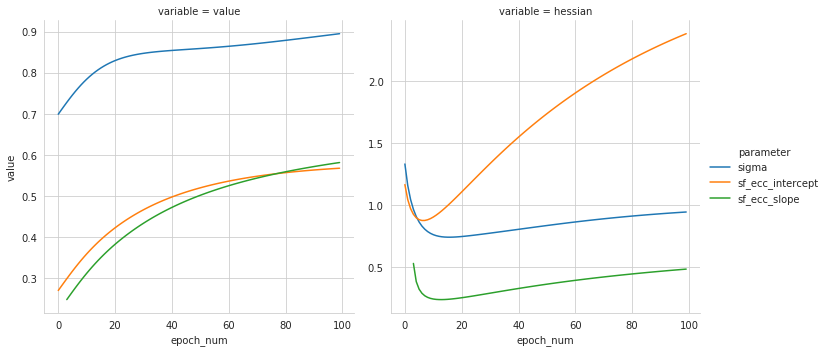

In [499]:
sns.relplot('epoch_num', 'value', 'parameter', col='variable', data=h.dropna().melt(['parameter', 'epoch_num'], ['value', 'hessian']), kind='line', facet_kws={'sharey': False})

In [331]:
dataset = sfp.model.FirstLevelDataset('tmp.csv', device)
dataloader = torchdata.DataLoader(dataset, len(dataset))

In [332]:
feat, target = next(iter(dataloader))
H = hessian.hessian(sfp.model.weighted_normed_loss(m(feat), target), [p for p in m.parameters() if p.requires_grad])

['sigma', 'abs_amplitude_cardinals', 'abs_amplitude_obliques', 'abs_mode_cardinals', 'abs_mode_obliques', 'sf_ecc_slope', 'sf_ecc_intercept']


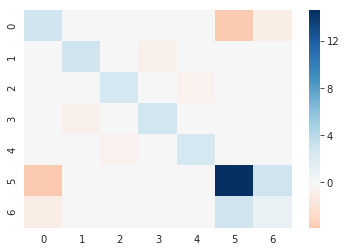

In [333]:
print([p[0] for p in m.named_parameters() if p[1].requires_grad])
sns.heatmap(H, cmap='RdBu', center=0)

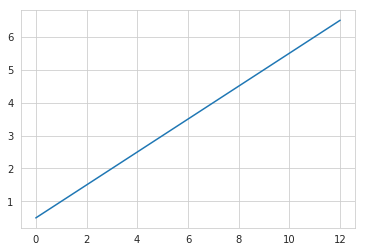

In [99]:
x = np.linspace(0, np.pi, 100)
e = np.linspace(0, 12, 100)
a = m.preferred_period(0, e, 0).detach().numpy()
plt.plot(e, a)

# Analyzing outputs

In [23]:
base_path = '/scratch/wfb229/spatial_frequency_preferences/derivatives/tuning_2d_model/stim_class/posterior/sub-wlsubj045/ses-02/sub-wlsubj045_ses-02_task-sfp_v1_e1-12_summary_b1_r1e-3_g1_all_'
base_path = '/mnt/winawerlab/Projects/spatial_frequency_preferences/BIDS/derivatives/tuning_2d_model/stim_class/posterior/sub-wlsubj045/ses-02/sub-wlsubj045_ses-02_task-sfp_v1_e1-12_summary_b1_r1e-3_g0_all_'
models = pd.read_csv(base_path+'model.csv')
loss_df = pd.read_csv(base_path+'loss.csv')
# results_df = pd.read_csv(base_path+'model_df.csv')

## Check parameter convegence?

## Learning hyperparameters

In [507]:
models, loss_df, _, model_history = sfp.analyze_model.combine_models('/mnt/winawerlab/Projects/spatial_frequency_preferences/BIDS/derivatives/tuning_2d_simulated/noise-stim_class_posterior_sub-wlsubj045_ses-02_task-sfp_v1_e1-12/learning_hyperparams_full/*', False)

In [556]:
# hack to deal with this issue, hopefully fixed soon: https://github.com/mwaskom/seaborn/issues/1560
loss_df.fit_model_type = loss_df.fit_model_type.apply(lambda x: {'full_donut_full_amps-vary': 'full_donut_full_amps-vary ', 'full_donut_iso_amps-constant': 'full_donut_iso_amps-constant '}.get(x, x))

In [557]:
timing_df = loss_df.groupby(['batch_size', 'learning_rate', 'fit_model_type', 'true_model_type', 'epoch_num'])[['time']].max().reset_index()

/home/billbrod/miniconda3/envs/sfp/lib/python3.6/site-packages/matplotlib/tight_layout.py:231: UserWarning: tight_layout : falling back to Agg renderer
  warnings.warn("tight_layout : falling back to Agg renderer")


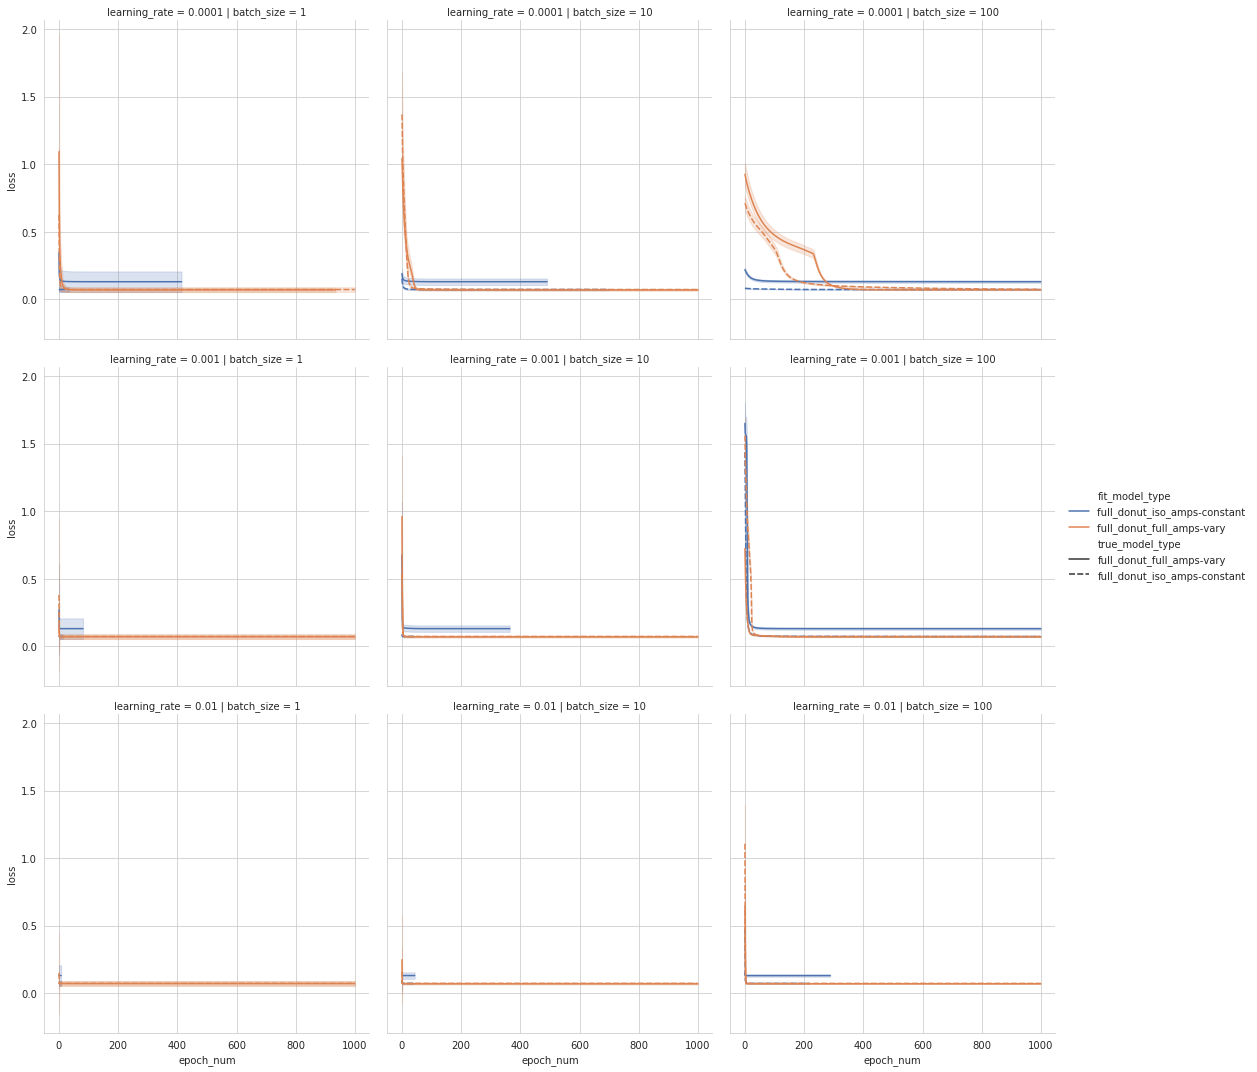

In [559]:
g = sns.relplot('epoch_num', 'loss', 'fit_model_type', style='true_model_type', data=loss_df, col='batch_size', row='learning_rate', 
                kind='line', ci='sd', palette=sns.color_palette('deep', 2) )
                #facet_kws={'sharey':False, 'sharex': False})
#g.set(ylim=(-.025, .05))

/home/billbrod/miniconda3/envs/sfp/lib/python3.6/site-packages/matplotlib/tight_layout.py:231: UserWarning: tight_layout : falling back to Agg renderer
  warnings.warn("tight_layout : falling back to Agg renderer")


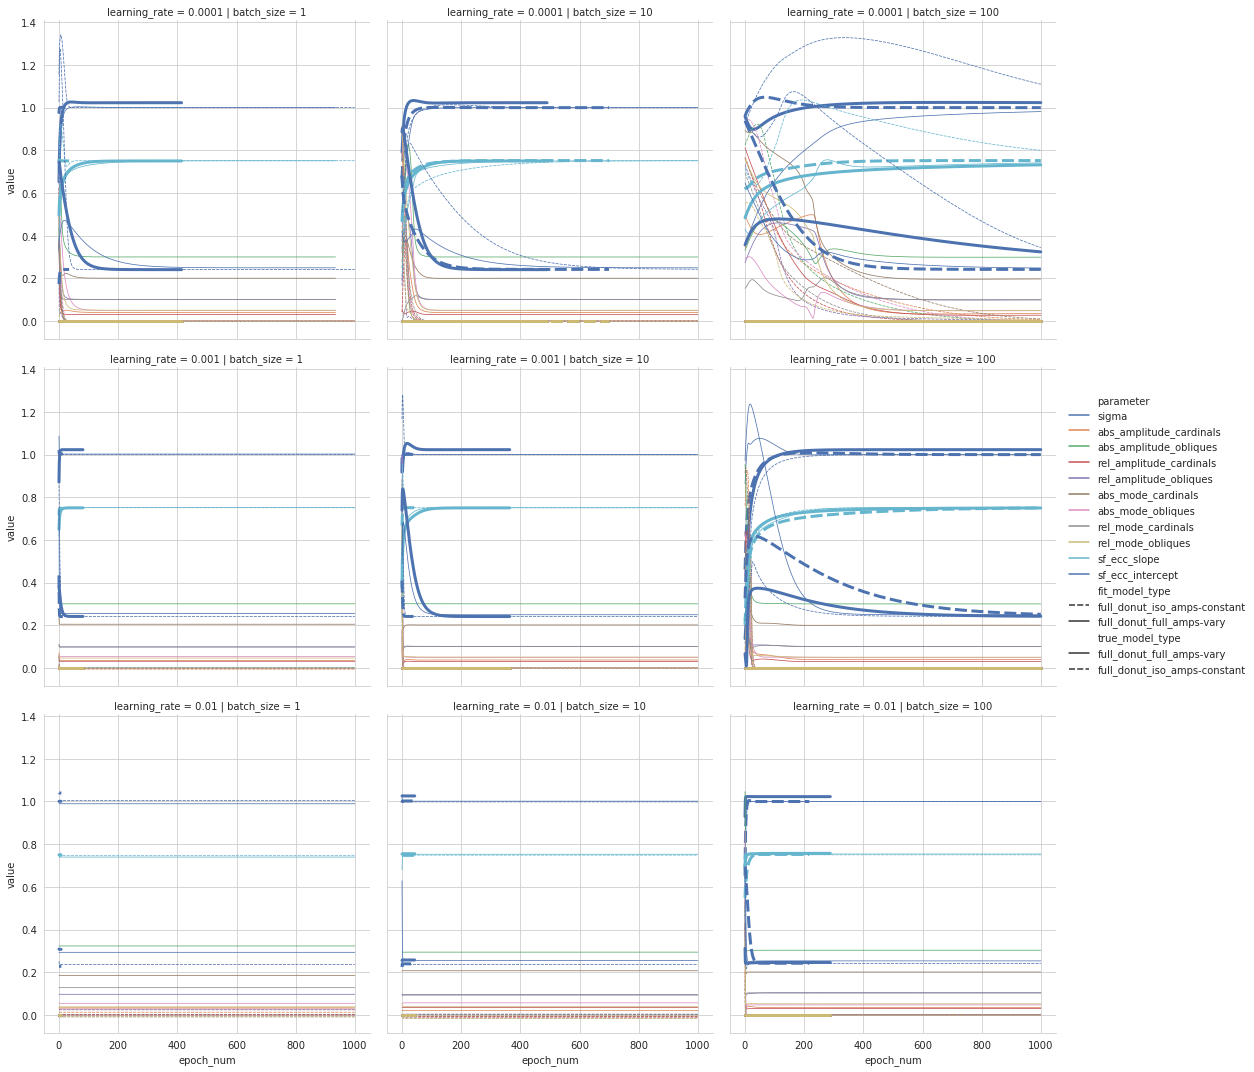

In [534]:
g=sns.relplot('epoch_num', 'value', 'parameter', size='fit_model_type', style='true_model_type', col='batch_size', row='learning_rate', data=model_history, kind='line', 
              ci='sd', palette=sns.color_palette('deep', 11))#facet_kws={'sharey': False})

/home/billbrod/miniconda3/envs/sfp/lib/python3.6/site-packages/matplotlib/tight_layout.py:231: UserWarning: tight_layout : falling back to Agg renderer
  warnings.warn("tight_layout : falling back to Agg renderer")


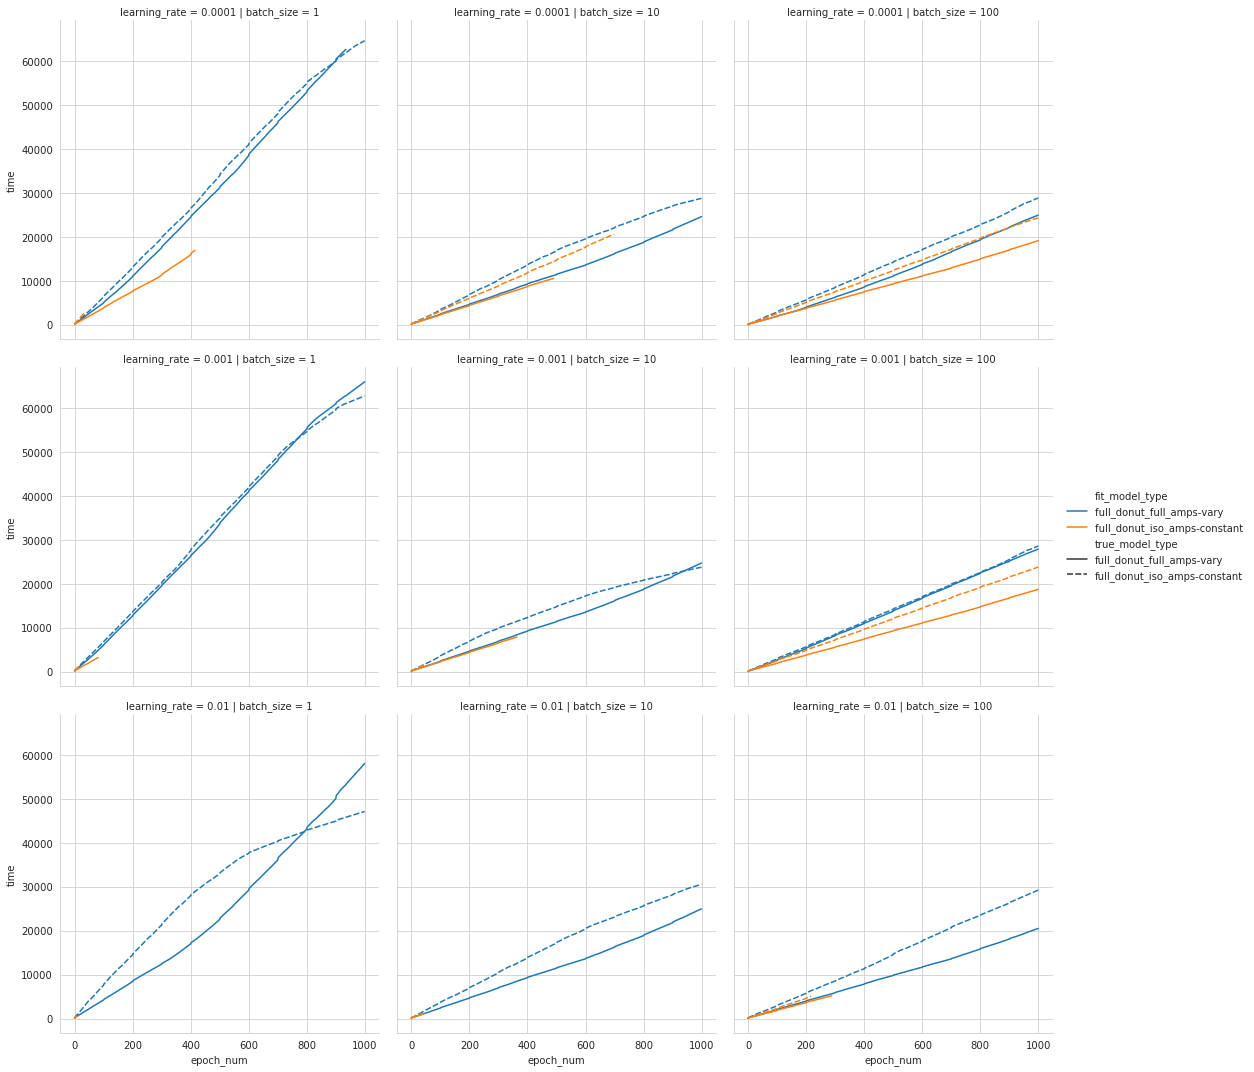

In [558]:
g=sns.relplot('epoch_num', 'time', 'fit_model_type', style='true_model_type', data=timing_df, col='batch_size', row='learning_rate', kind='line', legend='full')

In [562]:
grouped_loss = loss_df.groupby(['true_model_type', 'fit_model_type', 'learning_rate', 'batch_size', 'epoch_num']).loss.mean().reset_index()
grouped_loss = grouped_loss.groupby(['true_model_type', 'fit_model_type', 'learning_rate', 'batch_size']).last().reset_index()

/home/billbrod/miniconda3/envs/sfp/lib/python3.6/site-packages/matplotlib/tight_layout.py:231: UserWarning: tight_layout : falling back to Agg renderer
  warnings.warn("tight_layout : falling back to Agg renderer")


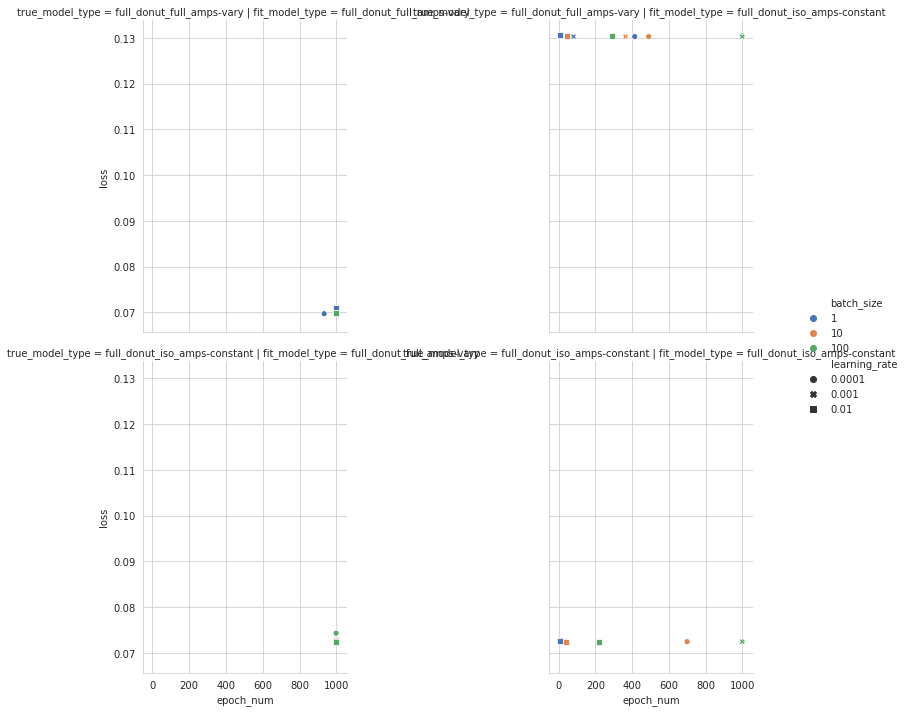

In [563]:
sns.relplot('epoch_num', 'loss', 'batch_size', style='learning_rate', data=grouped_loss, col='fit_model_type', row='true_model_type', legend='full', palette=sns.color_palette('deep', 3))

In [8]:
tmp = grouped_loss.rename(columns={'epoch_num': 'epochs_trained'}).set_index(['fit_model_type', 'learning_rate', 'batch_size', 'epochs_trained'])
models = models.set_index(['fit_model_type', 'learning_rate', 'batch_size', 'epochs_trained'])
models = models.join(tmp).reset_index()

In [ ]:
params = models.pivot_table('fit_value', ['batch_size', 'learning_rate', 'fit_model_type'], 'model_parameter')

In [ ]:
params

/home/billbrod/miniconda3/envs/sfp/lib/python3.6/site-packages/matplotlib/tight_layout.py:231: UserWarning: tight_layout : falling back to Agg renderer
  warnings.warn("tight_layout : falling back to Agg renderer")


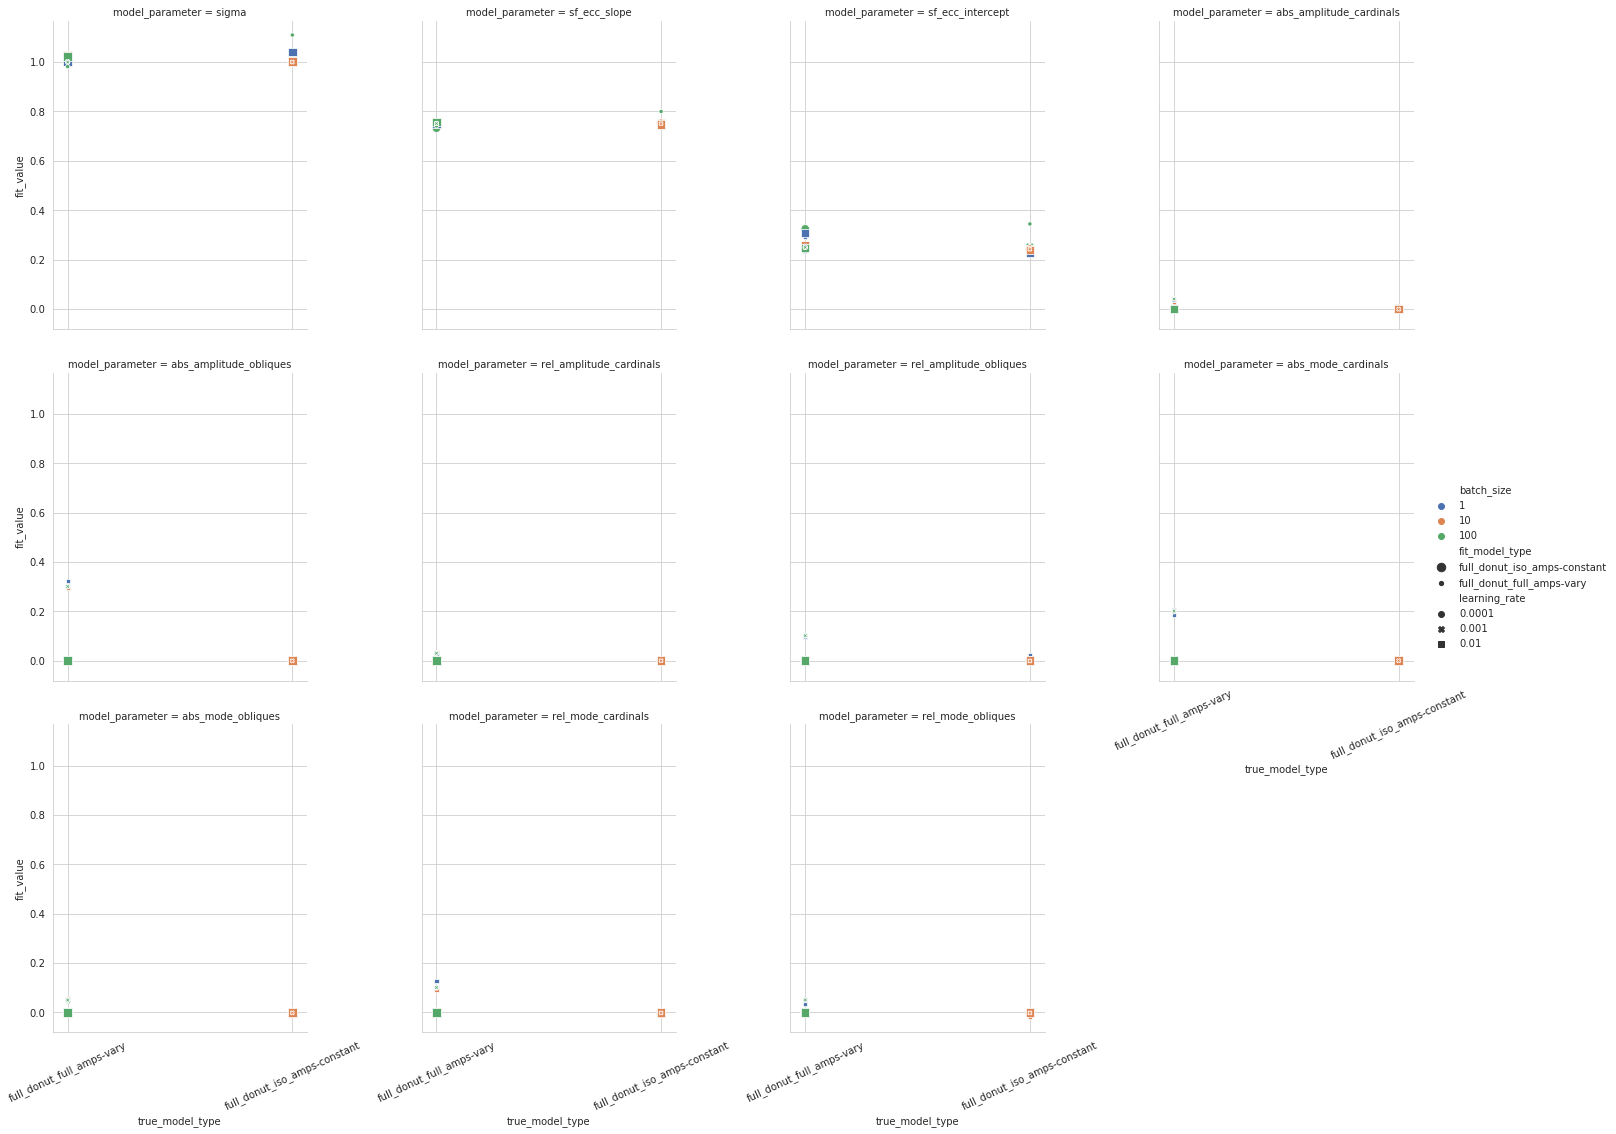

In [566]:
param_col_order = ['sigma', 'sf_ecc_slope', 'sf_ecc_intercept']
param_col_order.extend(['%s_%s_%s' % (i, j ,k) for j, i, k in itertools.product(['amplitude', 'mode'], ['abs', 'rel'], ['cardinals', 'obliques'])])

def custom_hline(y, xmin, xmax, **kwargs):
    data = kwargs.pop('data')
    kwargs.pop('color')
    if data[y].nunique() > 1:
        warnings.warn("No unique value for %s, so can't plot!" % y)
    else:
        plt.hlines(data[y].unique()[0], xmin, xmax, **kwargs)

g = sns.relplot('true_model_type', 'fit_value', 'batch_size', data=models, col='model_parameter', style='learning_rate', size='fit_model_type',
                palette=sns.color_palette('deep', 3), col_wrap=4, col_order=param_col_order,)
#g.map_dataframe(custom_hline, 'true_value', -.1, 1.1, linestyles='dashed')
for ax in g.axes.flatten():
    labels = ax.get_xticklabels()
    if labels:
        ax.set_xticklabels(labels, rotation=25)

## Some simulated model recovery

In [2]:
models, loss_df, results_df = sfp.analyze_model.combine_models('/mnt/winawerlab/Projects/spatial_frequency_preferences/BIDS/derivatives/tuning_2d_simulated/noise-stim_class_posterior_sub-wlsubj045_ses-02_task-sfp_v1_e1-12/model_recovery/*', False)

../sfp/model.py:178: UserWarning: When eccentricity_type is constant, sf_ecc_slope must be 0! correcting...
  warnings.warn("When eccentricity_type is constant, sf_ecc_slope must be 0! "


In [43]:
timing_df = loss_df.groupby(['batch_size', 'learning_rate', 'fit_model_type', 'true_model_type'])[['epoch_num', 'time_elapsed']].max().reset_index()

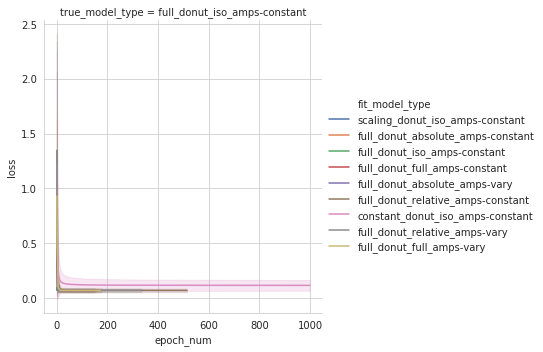

In [39]:
g = sns.relplot('epoch_num', 'loss', 'fit_model_type', col='true_model_type', data=loss_df, kind='line', ci='sd', palette=sns.color_palette('deep', 9) )
                #facet_kws={'sharey':False, 'sharex': False})
#g.set(ylim=(-.025, .05))

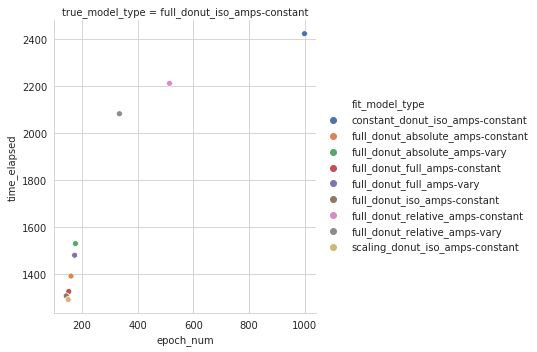

In [44]:
sns.relplot('epoch_num', 'time_elapsed', 'fit_model_type', data=timing_df, legend='full', col='true_model_type', palette=sns.color_palette('deep', 9))

In [9]:
grouped_loss = loss_df.groupby(['fit_model_type', 'true_model_type','epoch_num']).loss.mean().reset_index()
grouped_loss = grouped_loss.groupby(['fit_model_type', 'true_model_type']).last().reset_index()

In [10]:
grouped_loss

fit_model_type               true_model_type  epoch_num  \
0   constant_donut_iso_amps-constant  full_donut_iso_amps-constant        999   
1  full_donut_absolute_amps-constant  full_donut_iso_amps-constant        160   
2      full_donut_absolute_amps-vary  full_donut_iso_amps-constant        176   
3      full_donut_full_amps-constant  full_donut_iso_amps-constant        152   
4          full_donut_full_amps-vary  full_donut_iso_amps-constant        173   
5       full_donut_iso_amps-constant  full_donut_iso_amps-constant        143   
6  full_donut_relative_amps-constant  full_donut_iso_amps-constant        514   
7      full_donut_relative_amps-vary  full_donut_iso_amps-constant        334   
8    scaling_donut_iso_amps-constant  full_donut_iso_amps-constant        150   

       loss  
0  0.116981  
1  0.071353  
2  0.071746  
3  0.071260  
4  0.071707  
5  0.071357  
6  0.071203  
7  0.071467  
8  0.071959

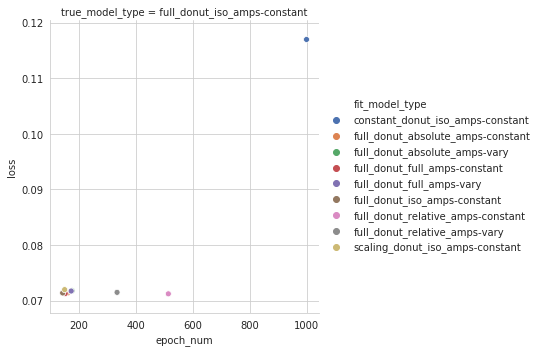

In [47]:
sns.relplot('epoch_num', 'loss', 'fit_model_type', data=grouped_loss, col='true_model_type', legend='full', palette=sns.color_palette('deep', 9))

In [8]:
params = models.pivot_table('fit_value', ['fit_model_type'], 'model_parameter')

In [9]:
params

model_parameter                    abs_amplitude_cardinals  \
fit_model_type                                               
constant_donut_iso_amps-constant                  0.000000   
full_donut_absolute_amps-constant                 0.000000   
full_donut_absolute_amps-vary                    -0.011018   
full_donut_full_amps-constant                     0.000000   
full_donut_full_amps-vary                         0.000715   
full_donut_iso_amps-constant                      0.000000   
full_donut_relative_amps-constant                 0.000000   
full_donut_relative_amps-vary                     0.000000   
scaling_donut_iso_amps-constant                   0.000000   

model_parameter                    abs_amplitude_obliques  abs_mode_cardinals  \
fit_model_type                                                                  
constant_donut_iso_amps-constant                 0.000000            0.000000   
full_donut_absolute_amps-constant                0.000000           -0.011520   
full_donut_absolute_amps-vary                    0.004781           -0.004742   
full_donut_full_amps-constant                    0.000000           -0.001186   
full_donut_full_amps-vary                        0.006739           -0.004117   
full_donut_iso_amps-constant                     0.000000            0.000000   
full_donut_relative_amps-constant                0.000000            0.000000   
full_donut_relative_amps-vary                    0.000000            0.000000   
scaling_donut_iso_amps-constant                  0.000000            0.000000   

model_parameter                    abs_mode_obliques  rel_amplitude_cardinals  \
fit_model_type                                                                  
constant_donut_iso_amps-constant            0.000000                 0.000000   
full_donut_absolute_amps-constant          -0.001031                 0.000000   
full_donut_absolute_amps-vary              -0.006799                 0.000000   
full_donut_full_amps-constant              -0.001167                 0.000000   
full_donut_full_amps-vary                  -0.002841                -0.013374   
full_donut_iso_amps-constant                0.000000                 0.000000   
full_donut_relative_amps-constant           0.000000                 0.000000   
full_donut_relative_amps-vary               0.000000                -0.024838   
scaling_donut_iso_amps-constant             0.000000                 0.000000   

model_parameter                    rel_amplitude_obliques  rel_mode_cardinals  \
fit_model_type                                                                  
constant_donut_iso_amps-constant                 0.000000            0.000000   
full_donut_absolute_amps-constant                0.000000            0.000000   
full_donut_absolute_amps-vary                    0.000000            0.000000   
full_donut_full_amps-constant                    0.000000           -0.010368   
full_donut_full_amps-vary                        0.001914           -0.008249   
full_donut_iso_amps-constant                     0.000000            0.000000   
full_donut_relative_amps-constant                0.000000           -0.009304   
full_donut_relative_amps-vary                    0.002215           -0.008902   
scaling_donut_iso_amps-constant                  0.000000            0.000000   

model_parameter                    rel_mode_obliques  sf_ecc_intercept  \
fit_model_type                                                           
constant_donut_iso_amps-constant            0.000000         10.834335   
full_donut_absolute_amps-constant           0.000000          0.206682   
full_donut_absolute_amps-vary               0.000000          0.201731   
full_donut_full_amps-constant              -0.000475          0.198708   
full_donut_full_amps-vary                   0.000060          0.207424   
full_donut_iso_amps-constant                0.000000          0.209470   
full_donut_relative_amps-constant          -0.000

In [7]:
models.pivot_table('true_value', ['fit_model_type'], 'model_parameter')

model_parameter                    abs_amplitude_cardinals  \
fit_model_type                                               
constant_donut_iso_amps-constant                       0.0   
full_donut_absolute_amps-constant                      0.0   
full_donut_absolute_amps-vary                          0.0   
full_donut_full_amps-constant                          0.0   
full_donut_full_amps-vary                              0.0   
full_donut_iso_amps-constant                           0.0   
full_donut_relative_amps-constant                      0.0   
full_donut_relative_amps-vary                          0.0   
scaling_donut_iso_amps-constant                        0.0   

model_parameter                    abs_amplitude_obliques  abs_mode_cardinals  \
fit_model_type                                                                  
constant_donut_iso_amps-constant                      0.0                 0.0   
full_donut_absolute_amps-constant                     0.0                 0.0   
full_donut_absolute_amps-vary                         0.0                 0.0   
full_donut_full_amps-constant                         0.0                 0.0   
full_donut_full_amps-vary                             0.0                 0.0   
full_donut_iso_amps-constant                          0.0                 0.0   
full_donut_relative_amps-constant                     0.0                 0.0   
full_donut_relative_amps-vary                         0.0                 0.0   
scaling_donut_iso_amps-constant                       0.0                 0.0   

model_parameter                    abs_mode_obliques  rel_amplitude_cardinals  \
fit_model_type                                                                  
constant_donut_iso_amps-constant                 0.0                      0.0   
full_donut_absolute_amps-constant                0.0                      0.0   
full_donut_absolute_amps-vary                    0.0                      0.0   
full_donut_full_amps-constant                    0.0                      0.0   
full_donut_full_amps-vary                        0.0                      0.0   
full_donut_iso_amps-constant                     0.0                      0.0   
full_donut_relative_amps-constant                0.0                      0.0   
full_donut_relative_amps-vary                    0.0                      0.0   
scaling_donut_iso_amps-constant                  0.0                      0.0   

model_parameter                    rel_amplitude_obliques  rel_mode_cardinals  \
fit_model_type                                                                  
constant_donut_iso_amps-constant                      0.0                 0.0   
full_donut_absolute_amps-constant                     0.0                 0.0   
full_donut_absolute_amps-vary                         0.0                 0.0   
full_donut_full_amps-constant                         0.0                 0.0   
full_donut_full_amps-vary                             0.0                 0.0   
full_donut_iso_amps-constant                          0.0                 0.0   
full_donut_relative_amps-constant                     0.0                 0.0   
full_donut_relative_amps-vary                         0.0                 0.0   
scaling_donut_iso_amps-constant                       0.0                 0.0   

model_parameter                    rel_mode_obliques  sf_ecc_intercept  \
fit_model_type                                                           
constant_donut_iso_amps-constant                 0.0              0.25   
full_donut_absolute_amps-constant                0.0              0.25   
full_donut_absolute_amps-vary                    0.0              0.25   
full_donut_full_amps-constant                    0.0              0.25   
full_donut_full_amps-vary                        0.0              0.25   
full_donut_iso_amps-constant                     0.0              0.25   
full_donut_relative_amps-constant                

In [11]:
tmp = grouped_loss.rename(columns={'epoch_num': 'epochs_trained'}).set_index(['fit_model_type', 'true_model_type', 'epochs_trained'])
models = models.set_index(['fit_model_type', 'true_model_type', 'epochs_trained'])
models = models.join(tmp).reset_index()

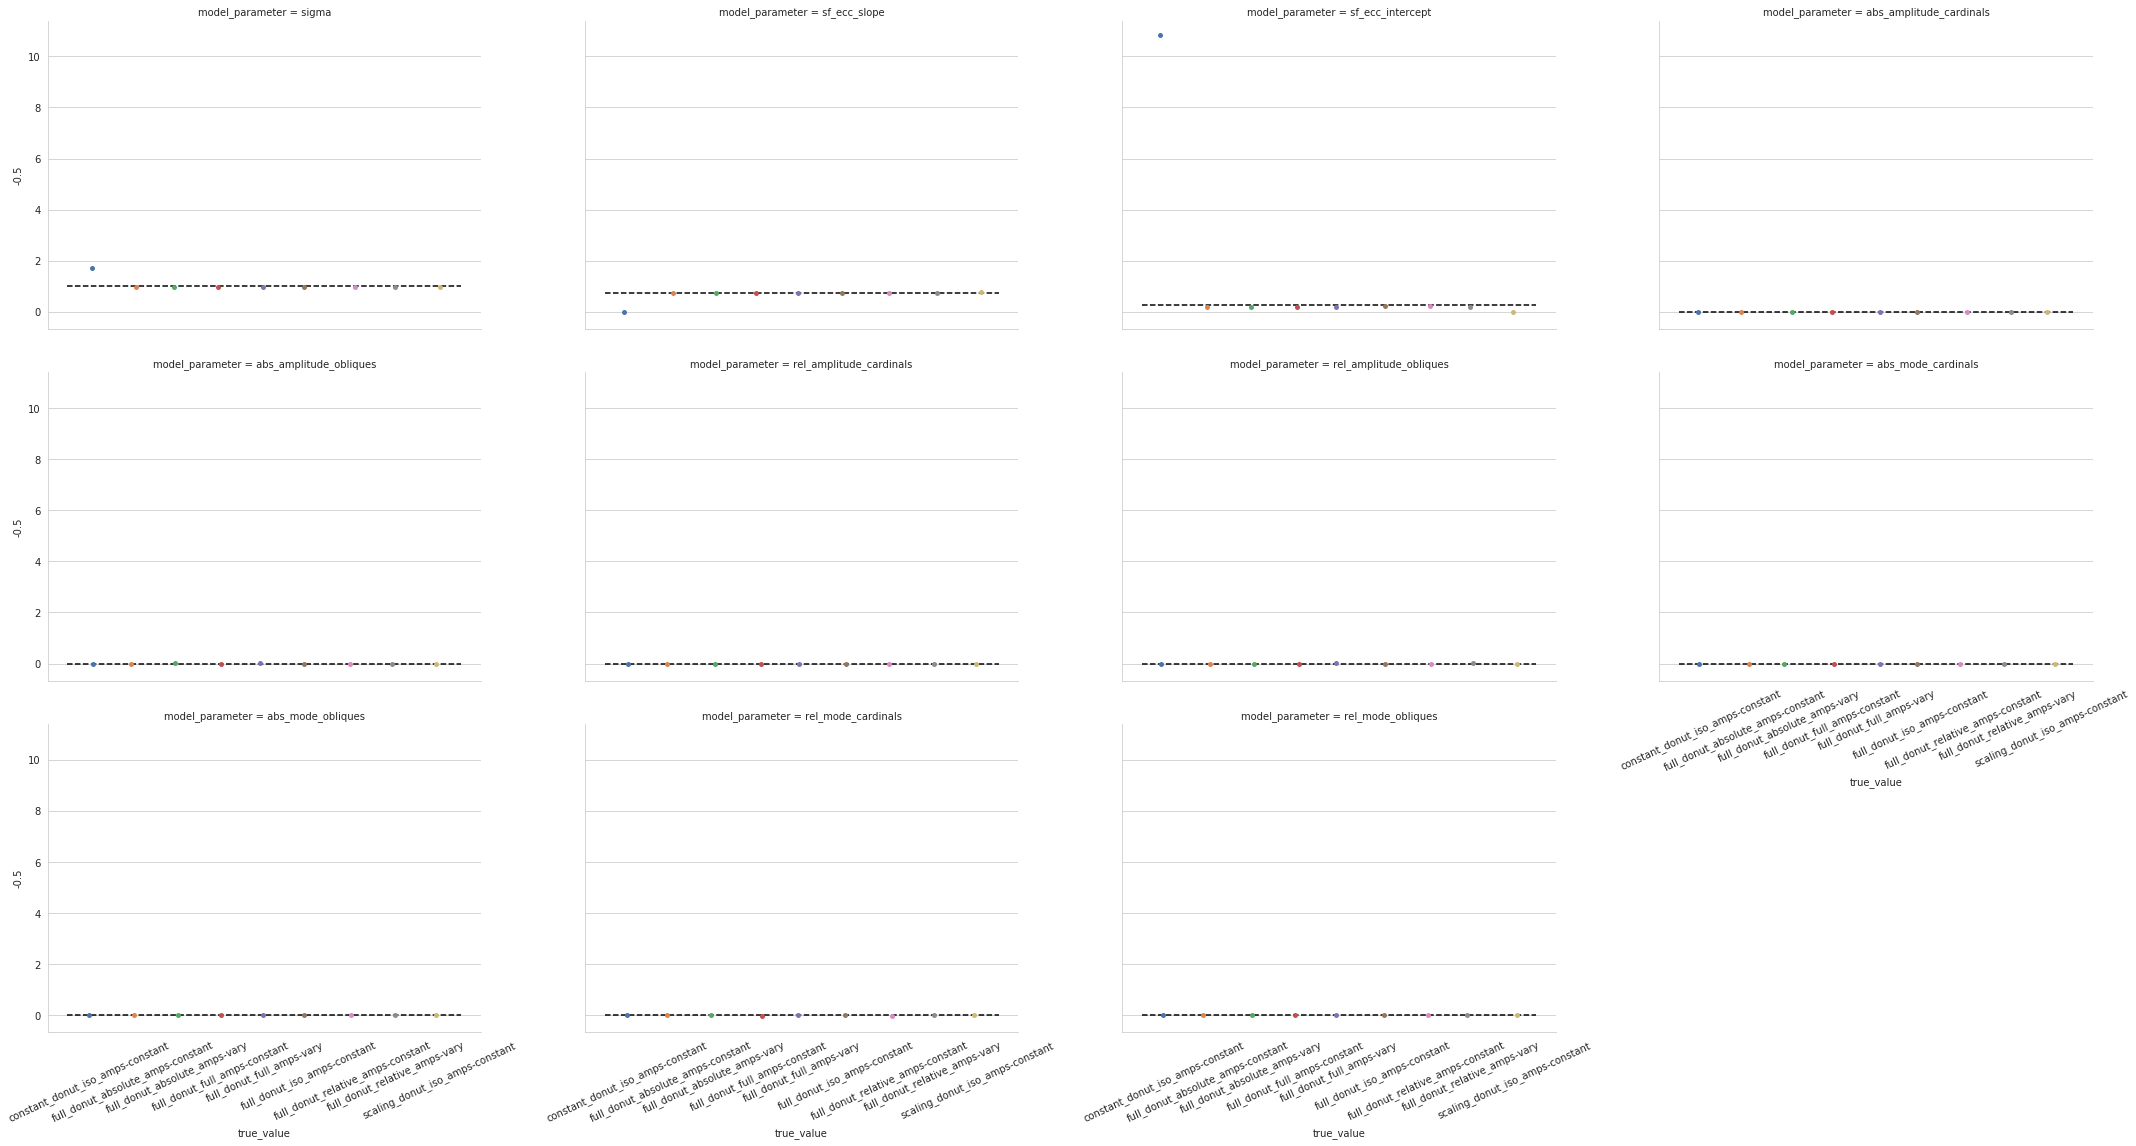

In [53]:
param_col_order = ['sigma', 'sf_ecc_slope', 'sf_ecc_intercept']
param_col_order.extend(['%s_%s_%s' % (i, j ,k) for j, i, k in itertools.product(['amplitude', 'mode'], ['abs', 'rel'], ['cardinals', 'obliques'])])

def custom_hline(y, xmin, xmax, **kwargs):
    data = kwargs.pop('data')
    kwargs.pop('color')
    if data[y].nunique() > 1:
        warnings.warn("No unique value for %s, so can't plot!" % y)
    else:
        plt.hlines(data[y].unique()[0], xmin, xmax, **kwargs)

g = sns.catplot('fit_model_type', 'fit_value', data=models, col='model_parameter',
                palette=sns.color_palette('deep', 9), col_wrap=4, col_order=param_col_order, aspect=1.5)
g.map_dataframe(custom_hline, 'true_value', -.5, 8.5, linestyles='dashed')
for ax in g.axes.flatten():
    labels = ax.get_xticklabels()
    if labels:
        ax.set_xticklabels(labels, rotation=25)

## Some simulated cross-validated model recovery

In [2]:
models, loss_df, results_df = sfp.analyze_model.combine_models('/mnt/winawerlab/Projects/spatial_frequency_preferences/BIDS/derivatives/tuning_2d_simulated/noise-stim_class_posterior_sub-wlsubj045_ses-02_task-sfp_v1_e1-12/model_recovery_cv/*', False)

../sfp/model.py:232: UserWarning: When eccentricity_type is constant, sf_ecc_slope must be 0! correcting...
  warnings.warn("When eccentricity_type is constant, sf_ecc_slope must be 0! "
../sfp/model.py:232: UserWarning: When eccentricity_type is constant, sf_ecc_slope must be 0! correcting...
  warnings.warn("When eccentricity_type is constant, sf_ecc_slope must be 0! "
../sfp/model.py:232: UserWarning: When eccentricity_type is constant, sf_ecc_slope must be 0! correcting...
  warnings.warn("When eccentricity_type is constant, sf_ecc_slope must be 0! "
../sfp/model.py:232: UserWarning: When eccentricity_type is constant, sf_ecc_slope must be 0! correcting...
  warnings.warn("When eccentricity_type is constant, sf_ecc_slope must be 0! "
../sfp/model.py:232: UserWarning: When eccentricity_type is constant, sf_ecc_slope must be 0! correcting...
  warnings.warn("When eccentricity_type is constant, sf_ecc_slope must be 0! "
../sfp/model.py:232: UserWarning: When eccentricity_type is const

In [3]:
timing_df = loss_df.groupby(['batch_size', 'learning_rate', 'fit_model_type', 'true_model_type', 'test_subset', 'data_subset'])[['epoch_num', 'time_elapsed']].max().reset_index()

In [33]:
g = sns.relplot('epoch_num', 'loss', hue='test_subset', col='fit_model_type', row='data_subset', data=loss_df, kind='line', ci='sd', palette=sns.color_palette('deep', 48) )
                #facet_kws={'sharey':False, 'sharex': False})
g.fig.savefig('losses.svg')
#g.set(ylim=(-.025, .05))

/home/billbrod/miniconda3/envs/sfp/lib/python3.6/site-packages/matplotlib/tight_layout.py:231: UserWarning: tight_layout : falling back to Agg renderer
  warnings.warn("tight_layout : falling back to Agg renderer")


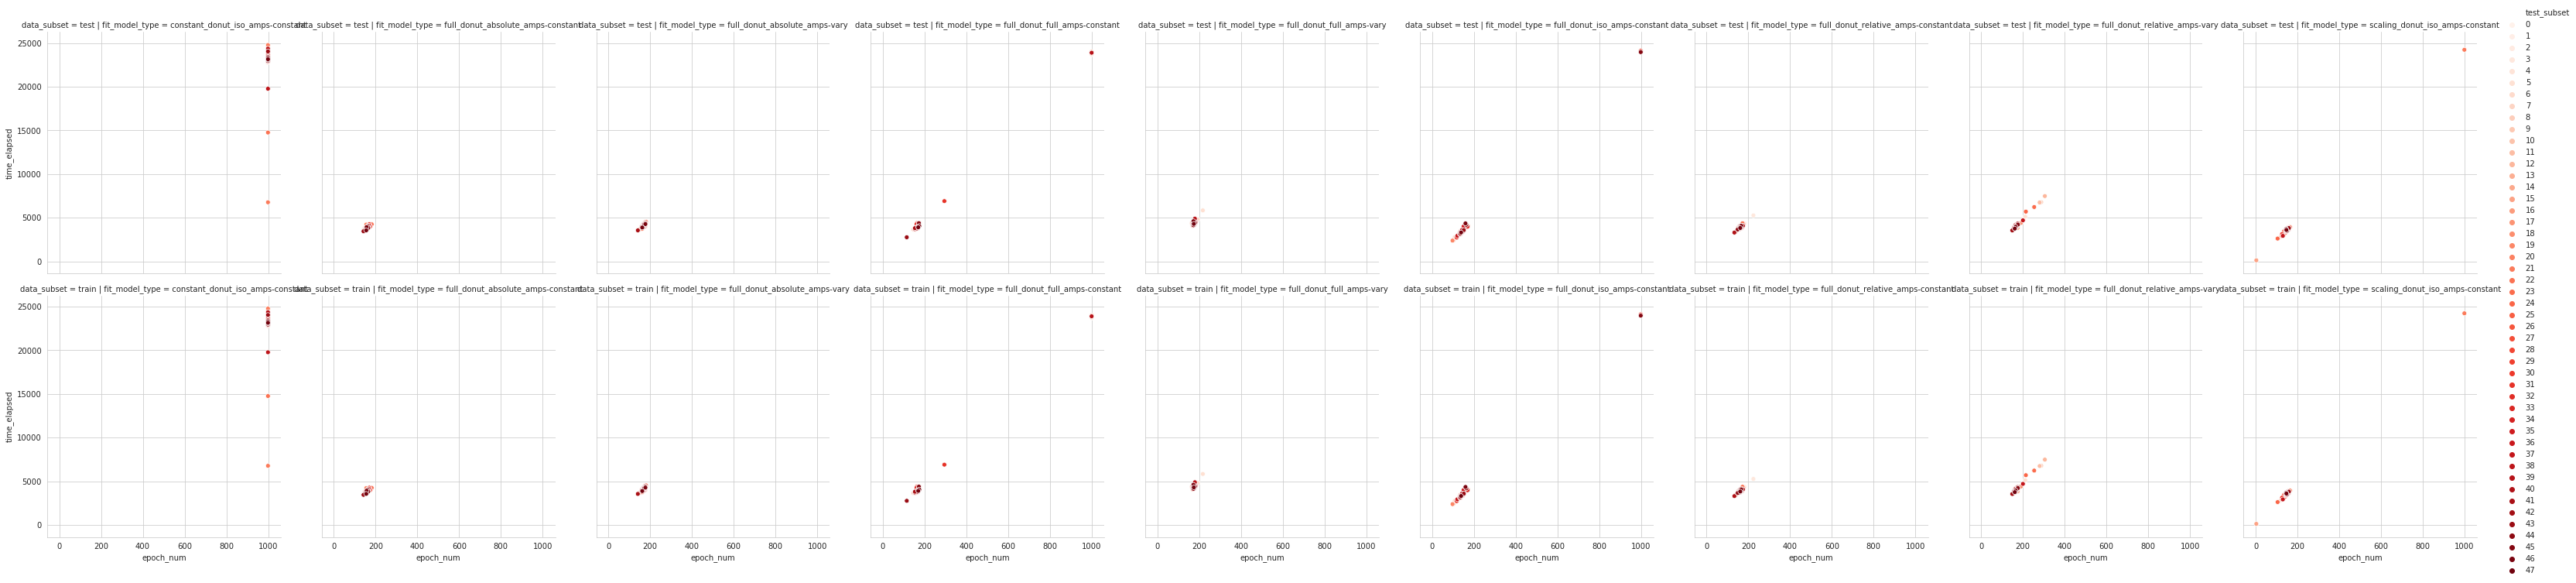

In [4]:
sns.relplot('epoch_num', 'time_elapsed', 'test_subset', col='fit_model_type', row='data_subset', data=timing_df, palette=sns.color_palette('Reds', 48))

In [6]:
grouped_loss = loss_df.groupby(['fit_model_type', 'true_model_type','epoch_num', 'test_subset', 'data_subset']).loss.mean().reset_index()
grouped_loss = grouped_loss.groupby(['fit_model_type', 'true_model_type', 'test_subset', 'data_subset']).last().reset_index()

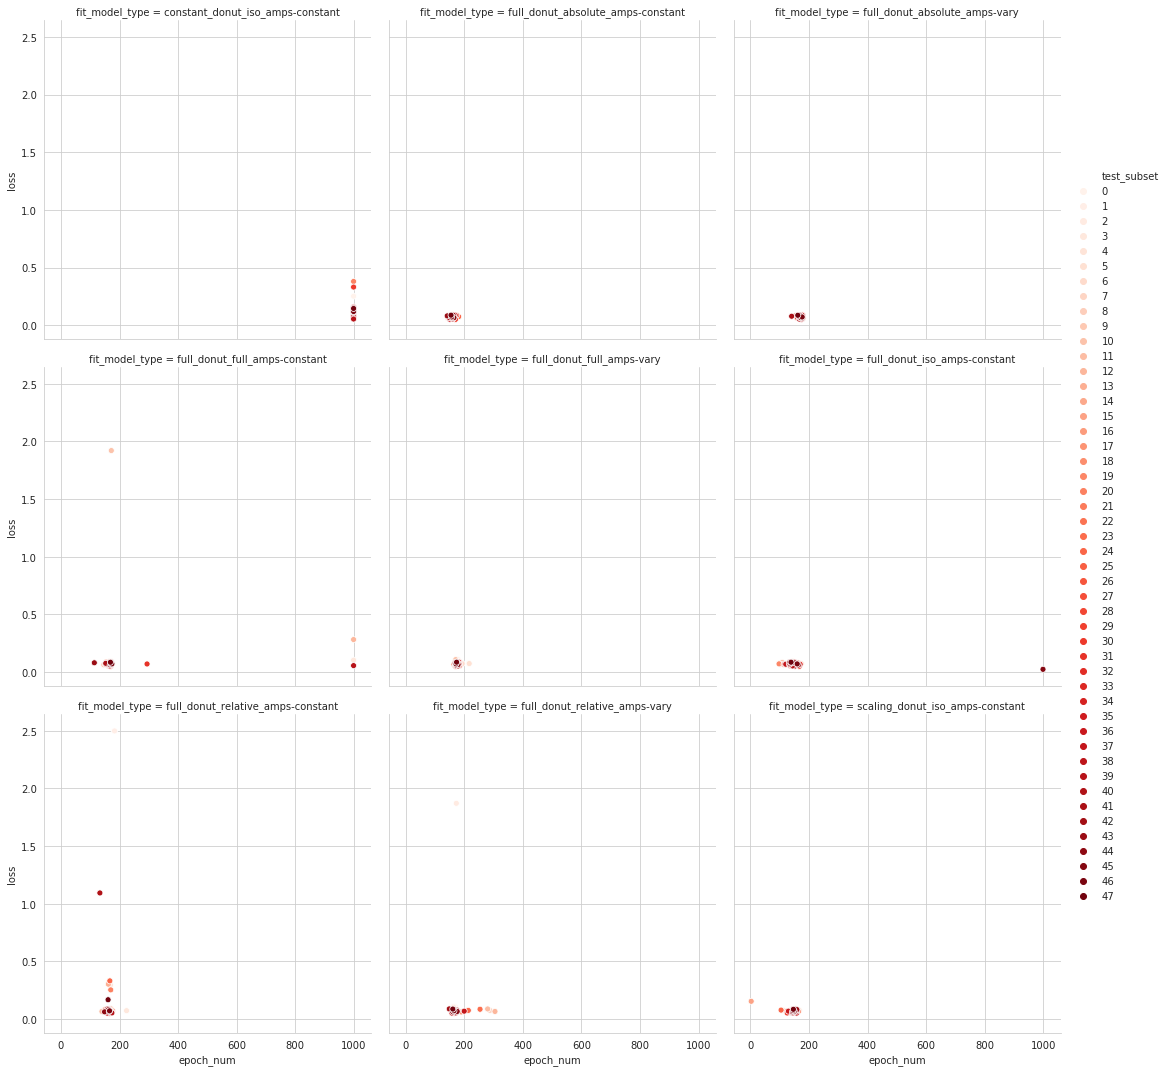

In [9]:
sns.relplot('epoch_num', 'loss', 'test_subset', data=grouped_loss[grouped_loss.data_subset=='test'], col='fit_model_type', col_wrap=3, palette=sns.color_palette('Reds', 48))

In [23]:
groupest_loss = grouped_loss.groupby(['fit_model_type', 'data_subset']).loss.mean().reset_index()
groupest_loss.pivot('data_subset', 'fit_model_type', 'loss')

fit_model_type  constant_donut_iso_amps-constant  \
data_subset                                        
test                                    0.116598   
train                                   0.221380   

fit_model_type  full_donut_absolute_amps-constant  \
data_subset                                         
test                                     0.071553   
train                                    0.071457   

fit_model_type  full_donut_absolute_amps-vary  full_donut_full_amps-constant  \
data_subset                                                                    
test                                 0.071650                       0.115294   
train                                0.071949                       0.106190   

fit_model_type  full_donut_full_amps-vary  full_donut_iso_amps-constant  \
data_subset                                                               
test                             0.073774                      0.070471   
train                            0.072170                      0.113363   

fit_model_type  full_donut_relative_amps-constant  \
data_subset                                         
test                                     0.163371   
train                                    0.141159   

fit_model_type  full_donut_relative_amps-vary  scaling_donut_iso_amps-constant  
data_subset                                                                     
test                                 0.111148                         0.073429  
train                                0.080931                         0.113397

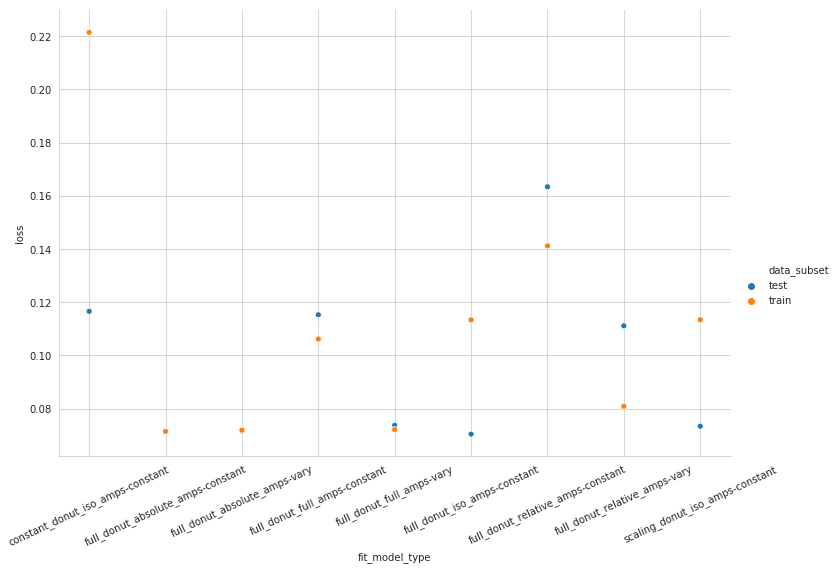

In [27]:
g = sns.relplot('fit_model_type', 'loss', 'data_subset', data=groupest_loss, height=7, aspect=1.5)
for ax in g.axes.flatten():
    labels = ax.get_xticklabels()
    if labels:
        ax.set_xticklabels(labels, rotation=25)

In [33]:
tmp = grouped_loss.rename(columns={'epoch_num': 'epochs_trained'}).set_index(['fit_model_type', 'true_model_type', 'epochs_trained', 'data_subset', 'test_subset'])
models = models.set_index(['fit_model_type', 'true_model_type', 'epochs_trained', 'data_subset', 'test_subset'])
models = models.join(tmp).reset_index()

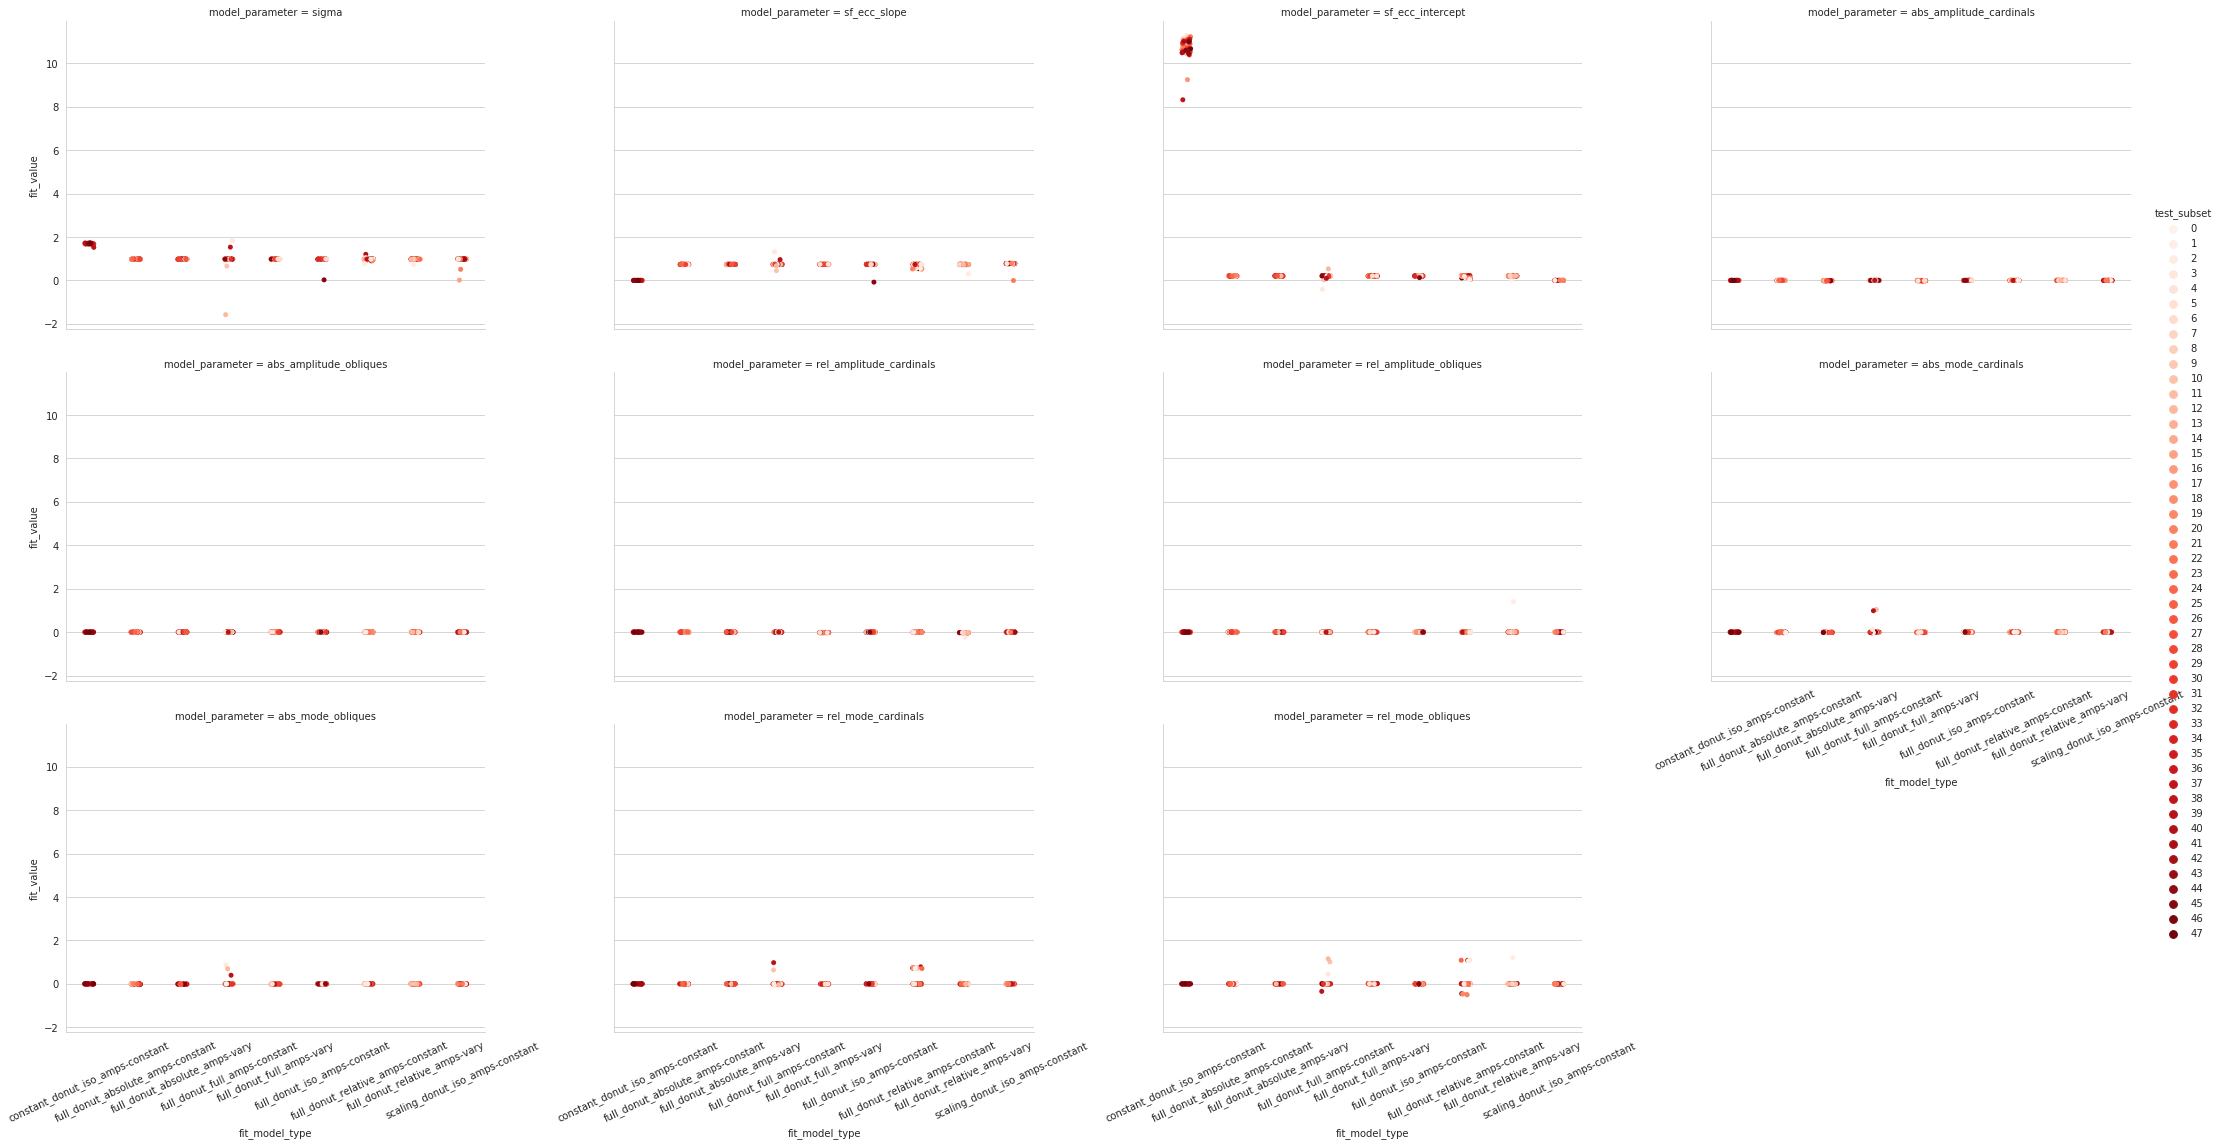

In [37]:
param_col_order = ['sigma', 'sf_ecc_slope', 'sf_ecc_intercept']
param_col_order.extend(['%s_%s_%s' % (i, j ,k) for j, i, k in itertools.product(['amplitude', 'mode'], ['abs', 'rel'], ['cardinals', 'obliques'])])

def custom_hline(y, xmin, xmax, **kwargs):
    data = kwargs.pop('data')
    kwargs.pop('color')
    if data[y].nunique() > 1:
        warnings.warn("No unique value for %s, so can't plot!" % y)
    else:
        plt.hlines(data[y].unique()[0], xmin, xmax, **kwargs)

g = sns.catplot('fit_model_type', 'fit_value', hue='test_subset', data=models, col='model_parameter',
                palette=sns.color_palette('Reds', 48), col_wrap=4, col_order=param_col_order, aspect=1.5)
#g.map_dataframe(custom_hline, 'true_value', -.5, 8.5, linestyles='dashed')
for ax in g.axes.flatten():
    labels = ax.get_xticklabels()
    if labels:
        ax.set_xticklabels(labels, rotation=25)

## First attempts at fits

In [13]:
models, loss_df, results_df = sfp.analyze_model.combine_models('/mnt/winawerlab/Projects/spatial_frequency_preferences/BIDS/derivatives/tuning_2d_model/stim_class/posterior/initial/sub-*/ses-*/*', False)

../sfp/model.py:178: UserWarning: When eccentricity_type is constant, sf_ecc_slope must be 0! correcting...
  warnings.warn("When eccentricity_type is constant, sf_ecc_slope must be 0! "
../sfp/model.py:178: UserWarning: When eccentricity_type is constant, sf_ecc_slope must be 0! correcting...
  warnings.warn("When eccentricity_type is constant, sf_ecc_slope must be 0! "
../sfp/model.py:178: UserWarning: When eccentricity_type is constant, sf_ecc_slope must be 0! correcting...
  warnings.warn("When eccentricity_type is constant, sf_ecc_slope must be 0! "
../sfp/model.py:178: UserWarning: When eccentricity_type is constant, sf_ecc_slope must be 0! correcting...
  warnings.warn("When eccentricity_type is constant, sf_ecc_slope must be 0! "


In [56]:
timing_df = loss_df.groupby(['subject', 'session', 'fit_model_type'])[['epochs_trained', 'time_elapsed']].max().reset_index()

/home/billbrod/miniconda3/envs/sfp/lib/python3.6/site-packages/matplotlib/tight_layout.py:231: UserWarning: tight_layout : falling back to Agg renderer
  warnings.warn("tight_layout : falling back to Agg renderer")


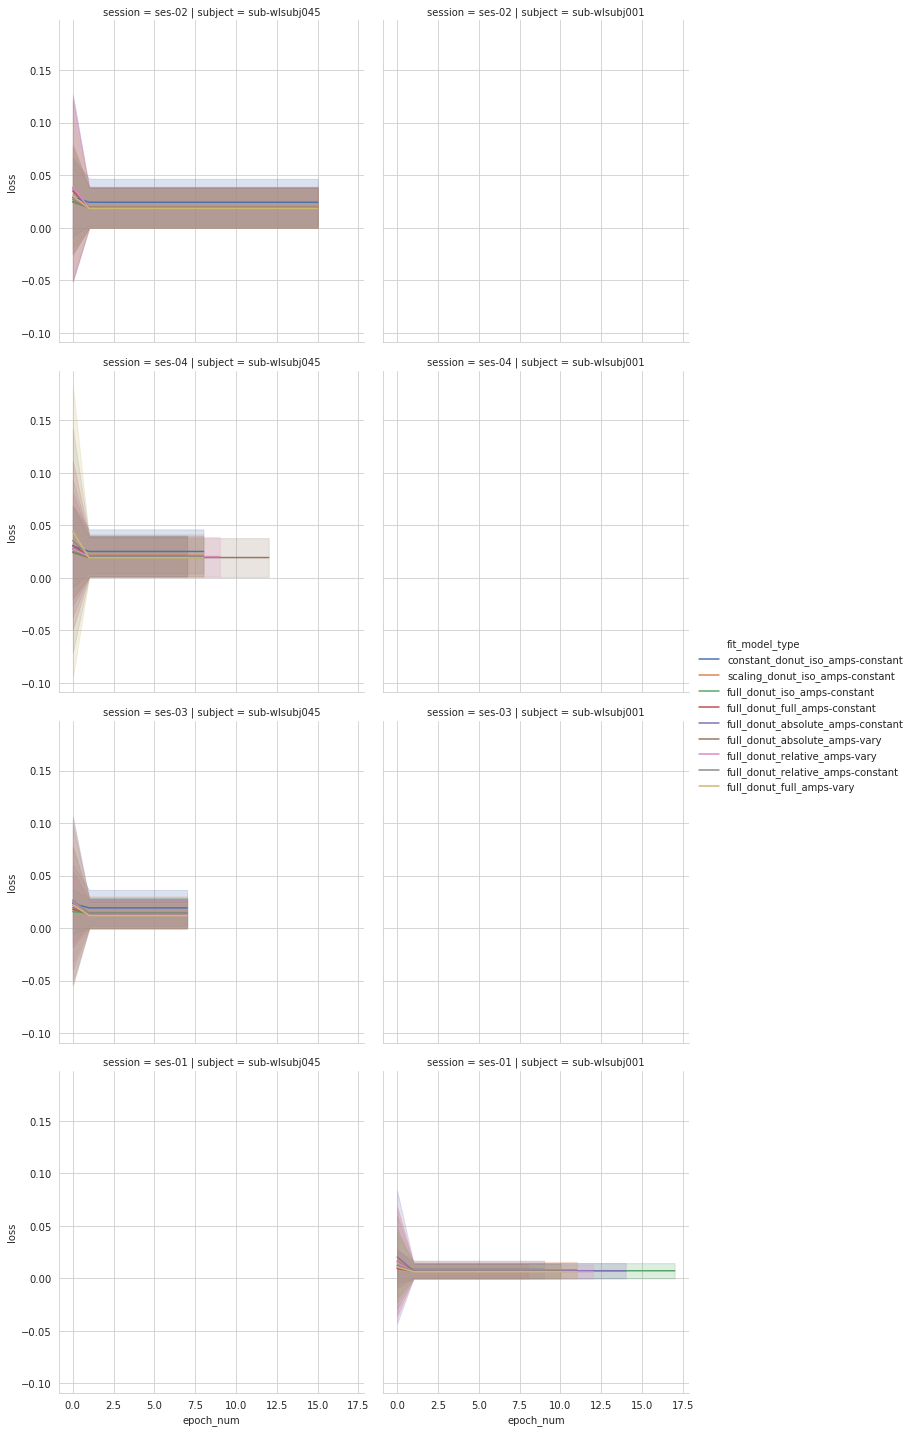

In [57]:
g = sns.relplot('epoch_num', 'loss', 'fit_model_type', col='subject', row='session', data=loss_df, kind='line', ci='sd', palette=sns.color_palette('deep', 9) )
                #facet_kws={'sharey':False, 'sharex': False})
#g.set(ylim=(-.025, .05))

/home/billbrod/miniconda3/envs/sfp/lib/python3.6/site-packages/matplotlib/tight_layout.py:231: UserWarning: tight_layout : falling back to Agg renderer
  warnings.warn("tight_layout : falling back to Agg renderer")


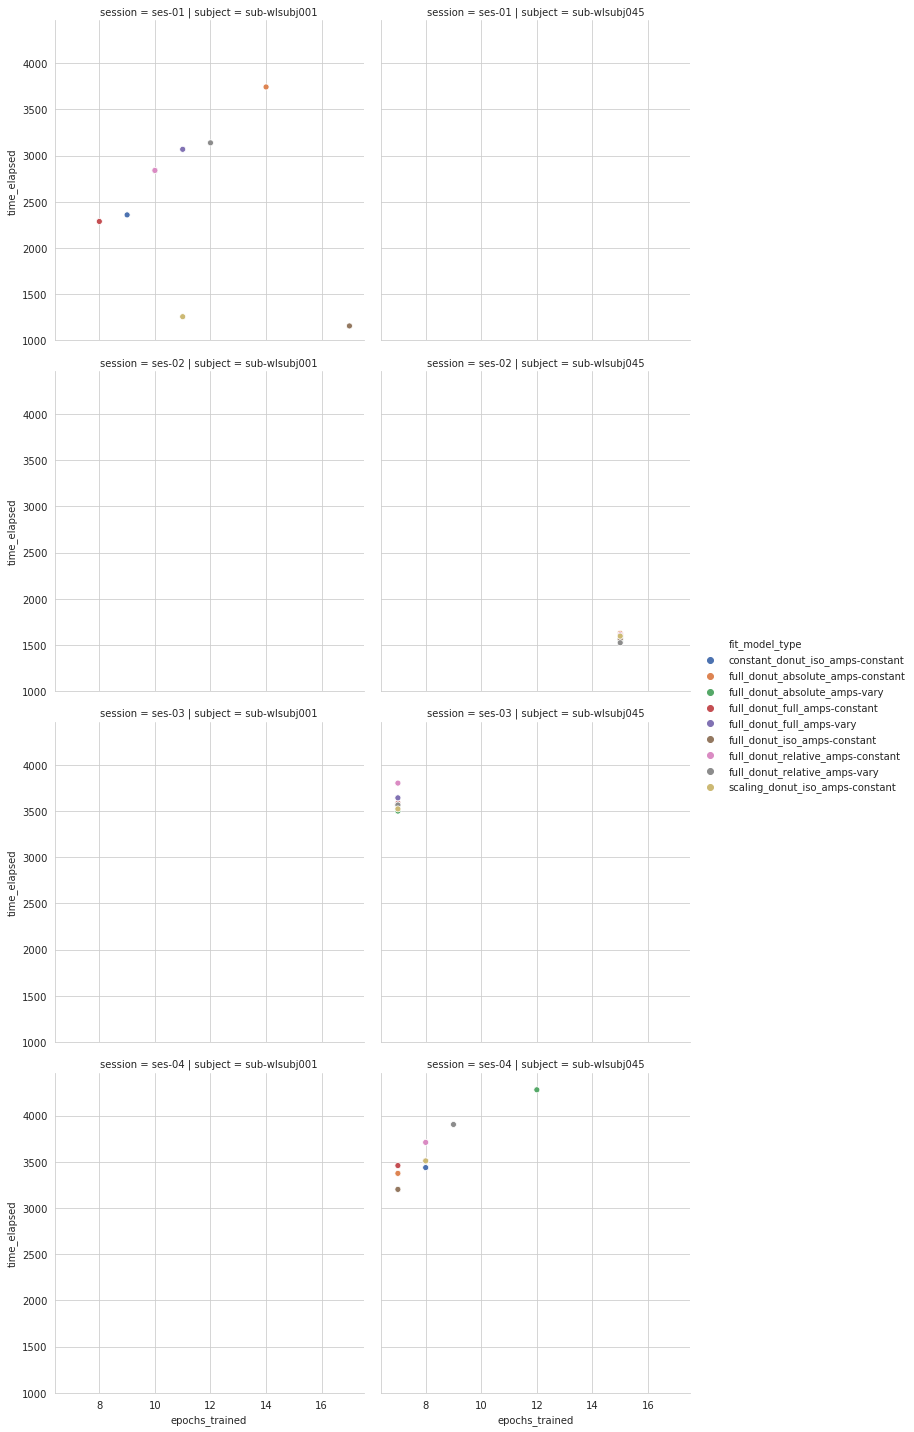

In [58]:
sns.relplot('epochs_trained', 'time_elapsed', 'fit_model_type',col='subject', row='session',  data=timing_df, legend='full',  palette=sns.color_palette('deep', 9))

In [59]:
grouped_loss = loss_df.groupby(['fit_model_type', 'subject', 'session', 'epochs_trained']).loss.mean().reset_index()
grouped_loss = grouped_loss.groupby(['fit_model_type', 'subject', 'session']).last().reset_index()

/home/billbrod/miniconda3/envs/sfp/lib/python3.6/site-packages/matplotlib/tight_layout.py:231: UserWarning: tight_layout : falling back to Agg renderer
  warnings.warn("tight_layout : falling back to Agg renderer")


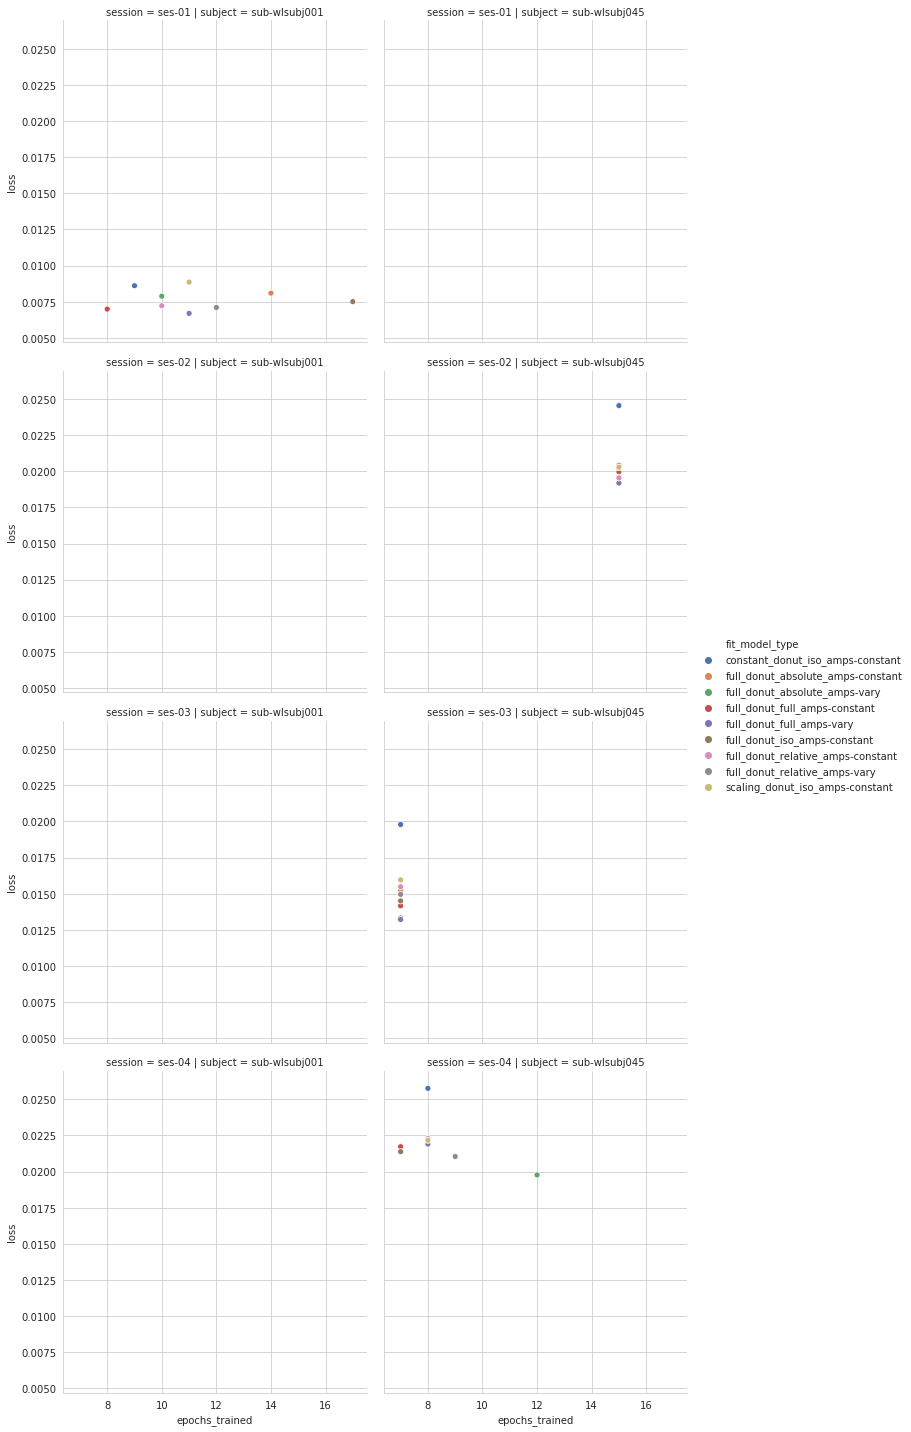

In [61]:
sns.relplot('epochs_trained', 'loss', 'fit_model_type', col='subject', row='session', data=grouped_loss, legend='full', palette=sns.color_palette('deep', 9))

In [19]:
params = models.pivot_table('fit_value', ['subject', 'session', 'fit_model_type'], 'model_parameter')

In [26]:
params.loc[('sub-wlsubj045', 'ses-04', 'full_donut_iso_amps-constant')].to_frame()

sub-wlsubj045
                                              ses-04
                        full_donut_iso_amps-constant
model_parameter                                     
abs_amplitude_cardinals                     0.000000
abs_amplitude_obliques                      0.000000
abs_mode_cardinals                          0.000000
abs_mode_obliques                           0.000000
rel_amplitude_cardinals                     0.000000
rel_amplitude_obliques                      0.000000
rel_mode_cardinals                          0.000000
rel_mode_obliques                           0.000000
sf_ecc_intercept                            0.391387
sf_ecc_slope                                0.189144
sigma                                       1.884379

In [22]:
params.loc[('sub-wlsubj045', 'ses-04', 'full_donut_full_amps-vary')].to_frame()

sub-wlsubj045
                                           ses-04
                        full_donut_full_amps-vary
model_parameter                                  
abs_amplitude_cardinals                  0.159799
abs_amplitude_obliques                   0.014478
abs_mode_cardinals                       0.081412
abs_mode_obliques                       -0.036094
rel_amplitude_cardinals                  0.038715
rel_amplitude_obliques                   0.014622
rel_mode_cardinals                      -0.071861
rel_mode_obliques                        0.013183
sf_ecc_intercept                         0.410408
sf_ecc_slope                             0.204171
sigma                                    1.871368

In [64]:
tmp = grouped_loss.set_index(['subject', 'session', 'fit_model_type',  'epochs_trained'])
models = models.set_index(['subject', 'session', 'fit_model_type', 'epochs_trained'])
models = models.join(tmp).reset_index()

/home/billbrod/miniconda3/envs/sfp/lib/python3.6/site-packages/matplotlib/tight_layout.py:231: UserWarning: tight_layout : falling back to Agg renderer
  warnings.warn("tight_layout : falling back to Agg renderer")


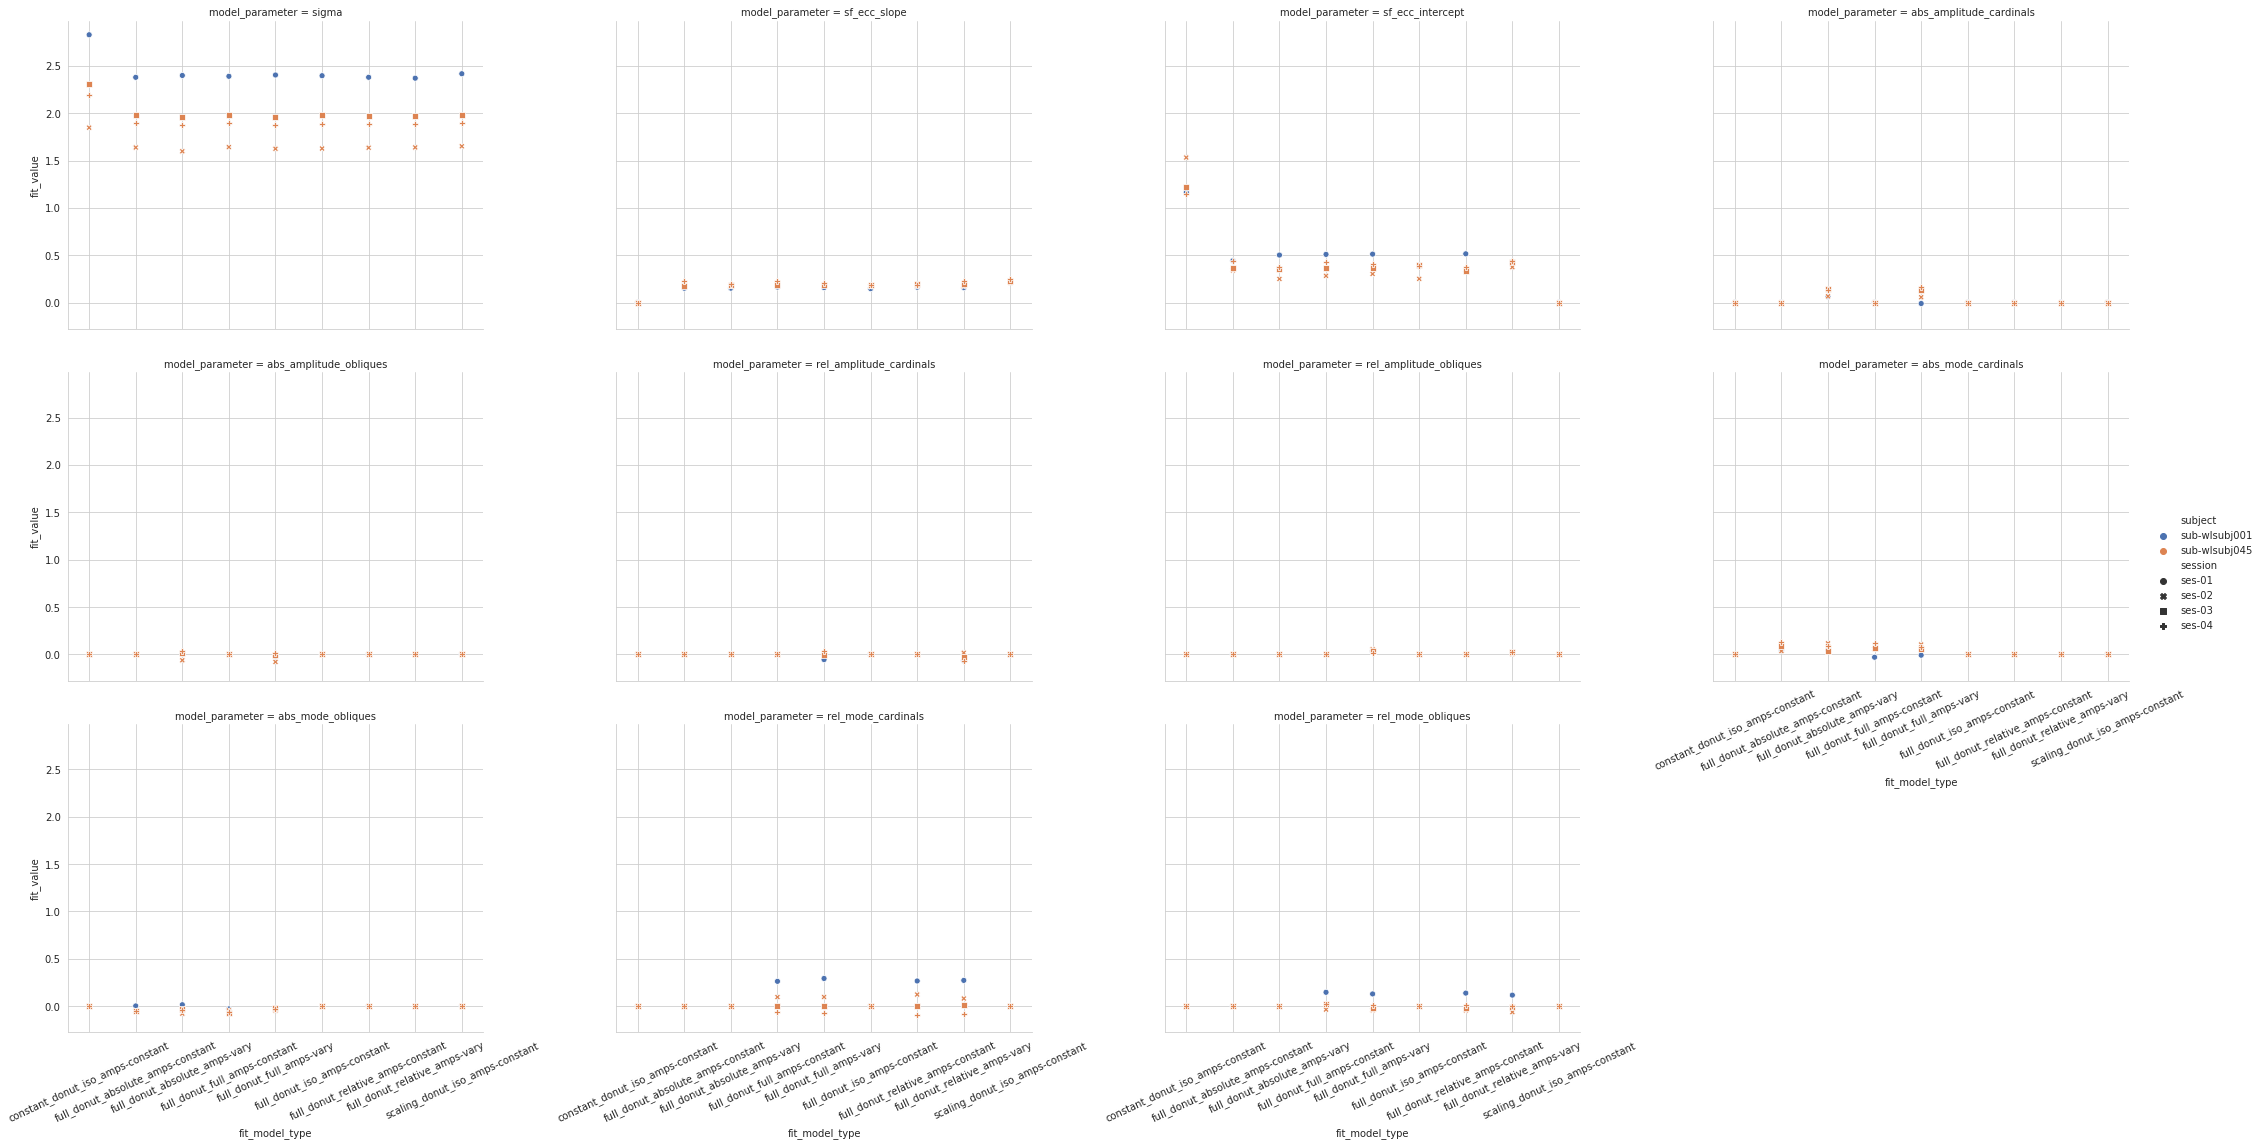

In [65]:
fit_model_type_order = ['constant_donut_iso_amps-constant', 'scaling_donut_iso_amps-constant', 'full_donut_iso_amps-constant',
                        'full_donut_relative_amps-constant', 'full_donut_absolute_amps-constant', 'full_donut_full_amps-constant',
                        'full_donut_relative_amps-vary', 'full_donut_absolute_amps-vary', 'full_donut_full_amps-vary']
param_col_order = ['sigma', 'sf_ecc_slope', 'sf_ecc_intercept']
param_col_order.extend(['%s_%s_%s' % (i, j ,k) for j, i, k in itertools.product(['amplitude', 'mode'], ['abs', 'rel'], ['cardinals', 'obliques'])])

def custom_hline(y, xmin, xmax, **kwargs):
    data = kwargs.pop('data')
    kwargs.pop('color')
    if data[y].nunique() > 1:
        warnings.warn("No unique value for %s, so can't plot!" % y)
    else:
        plt.hlines(data[y].unique()[0], xmin, xmax, **kwargs)

g = sns.relplot('fit_model_type', 'fit_value', 'subject', style='session', data=models, col='model_parameter', 
                palette=sns.color_palette('deep', 2), col_wrap=4, col_order=param_col_order, aspect=1.5)
#g.map_dataframe(custom_hline, 'true_value', -.5, 8.5, linestyles='dashed')
for ax in g.axes.flatten():
    labels = ax.get_xticklabels()
    if labels:
        ax.set_xticklabels(labels, rotation=25)

In [84]:
tmp_models = models.drop_duplicates('model')
features = sfp.analyze_model.create_feature_df(tmp_models.model.values, orientation_n_steps=48, retinotopic_angle_n_steps=48, subject=tmp_models.subject.values, 
                                               session=tmp_models.session.values, task=tmp_models.task.values)
example_oris = np.linspace(0, np.pi, num=4, endpoint=False)

/home/billbrod/miniconda3/envs/sfp/lib/python3.6/site-packages/matplotlib/tight_layout.py:231: UserWarning: tight_layout : falling back to Agg renderer
  warnings.warn("tight_layout : falling back to Agg renderer")


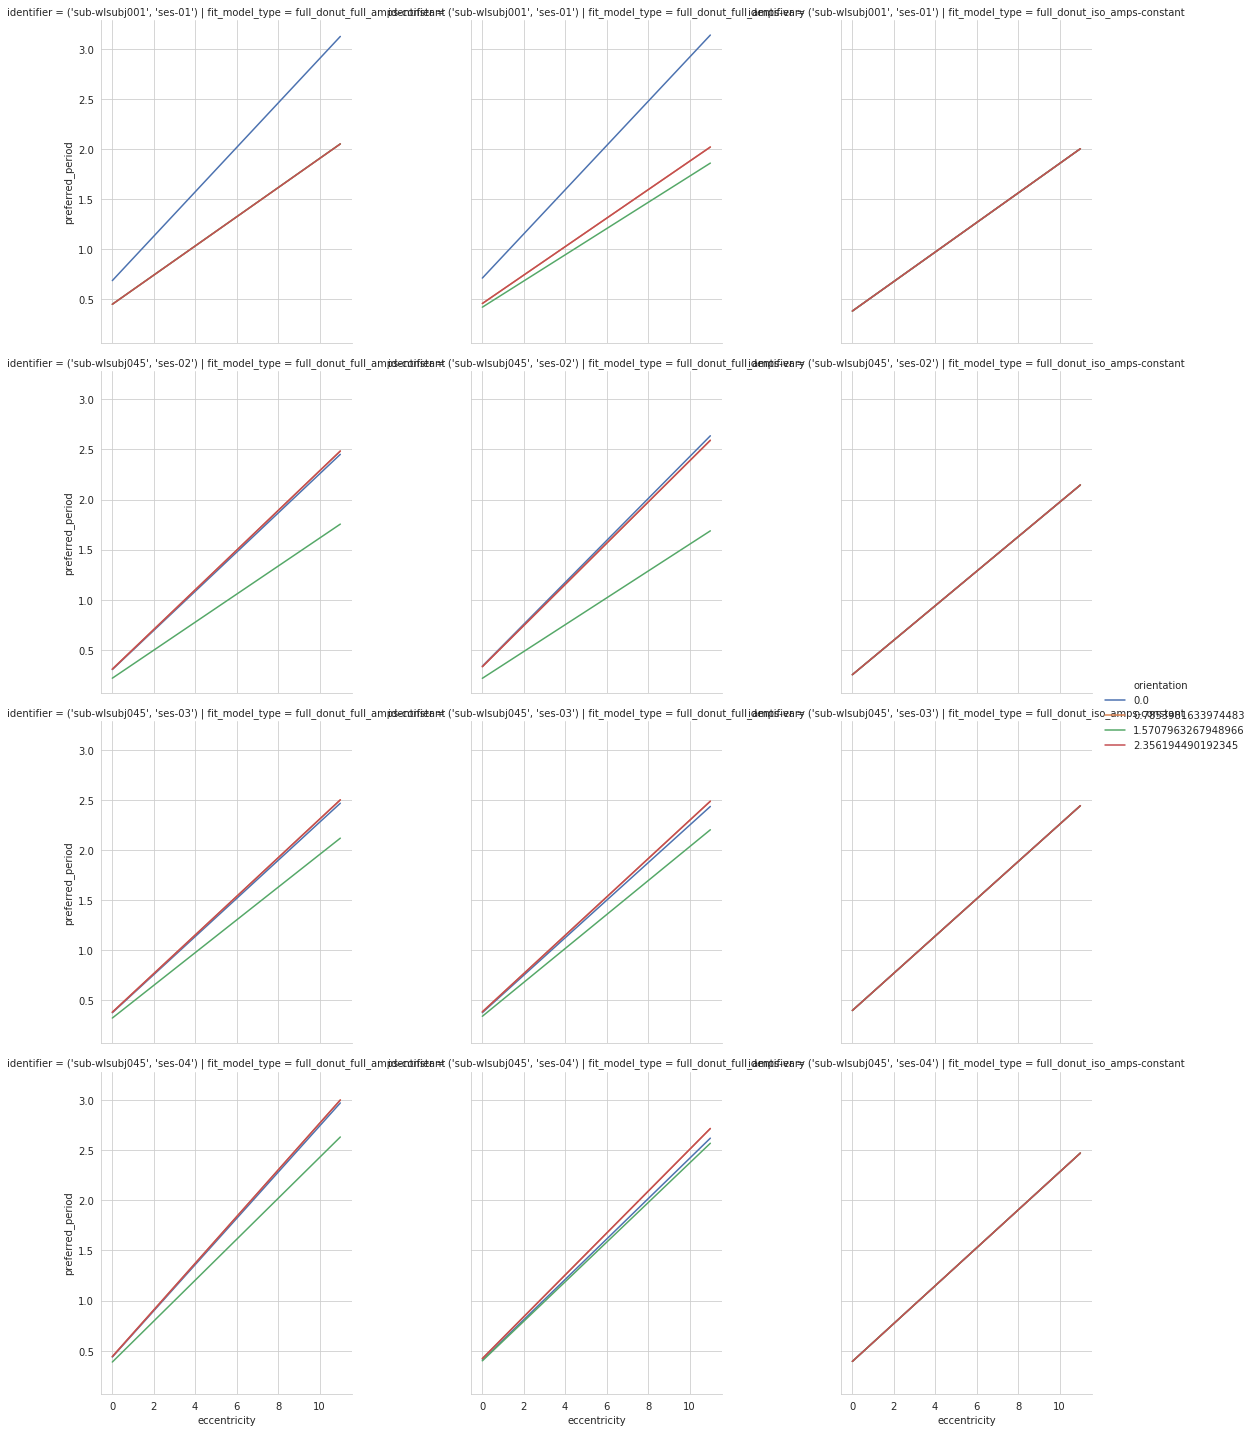

In [96]:
g = sns.relplot('eccentricity', 'preferred_period', 'orientation', data=features[(features.retinotopic_angle==0)&(features.orientation.isin(example_oris))&(features.fit_model_type.isin(['full_donut_iso_amps-constant', 'full_donut_full_amps-constant', 'full_donut_full_amps-vary']))],
                col='fit_model_type', row='identifier', kind='line', palette=sns.color_palette('deep', 4))

/home/billbrod/miniconda3/envs/sfp/lib/python3.6/site-packages/matplotlib/tight_layout.py:231: UserWarning: tight_layout : falling back to Agg renderer
  warnings.warn("tight_layout : falling back to Agg renderer")


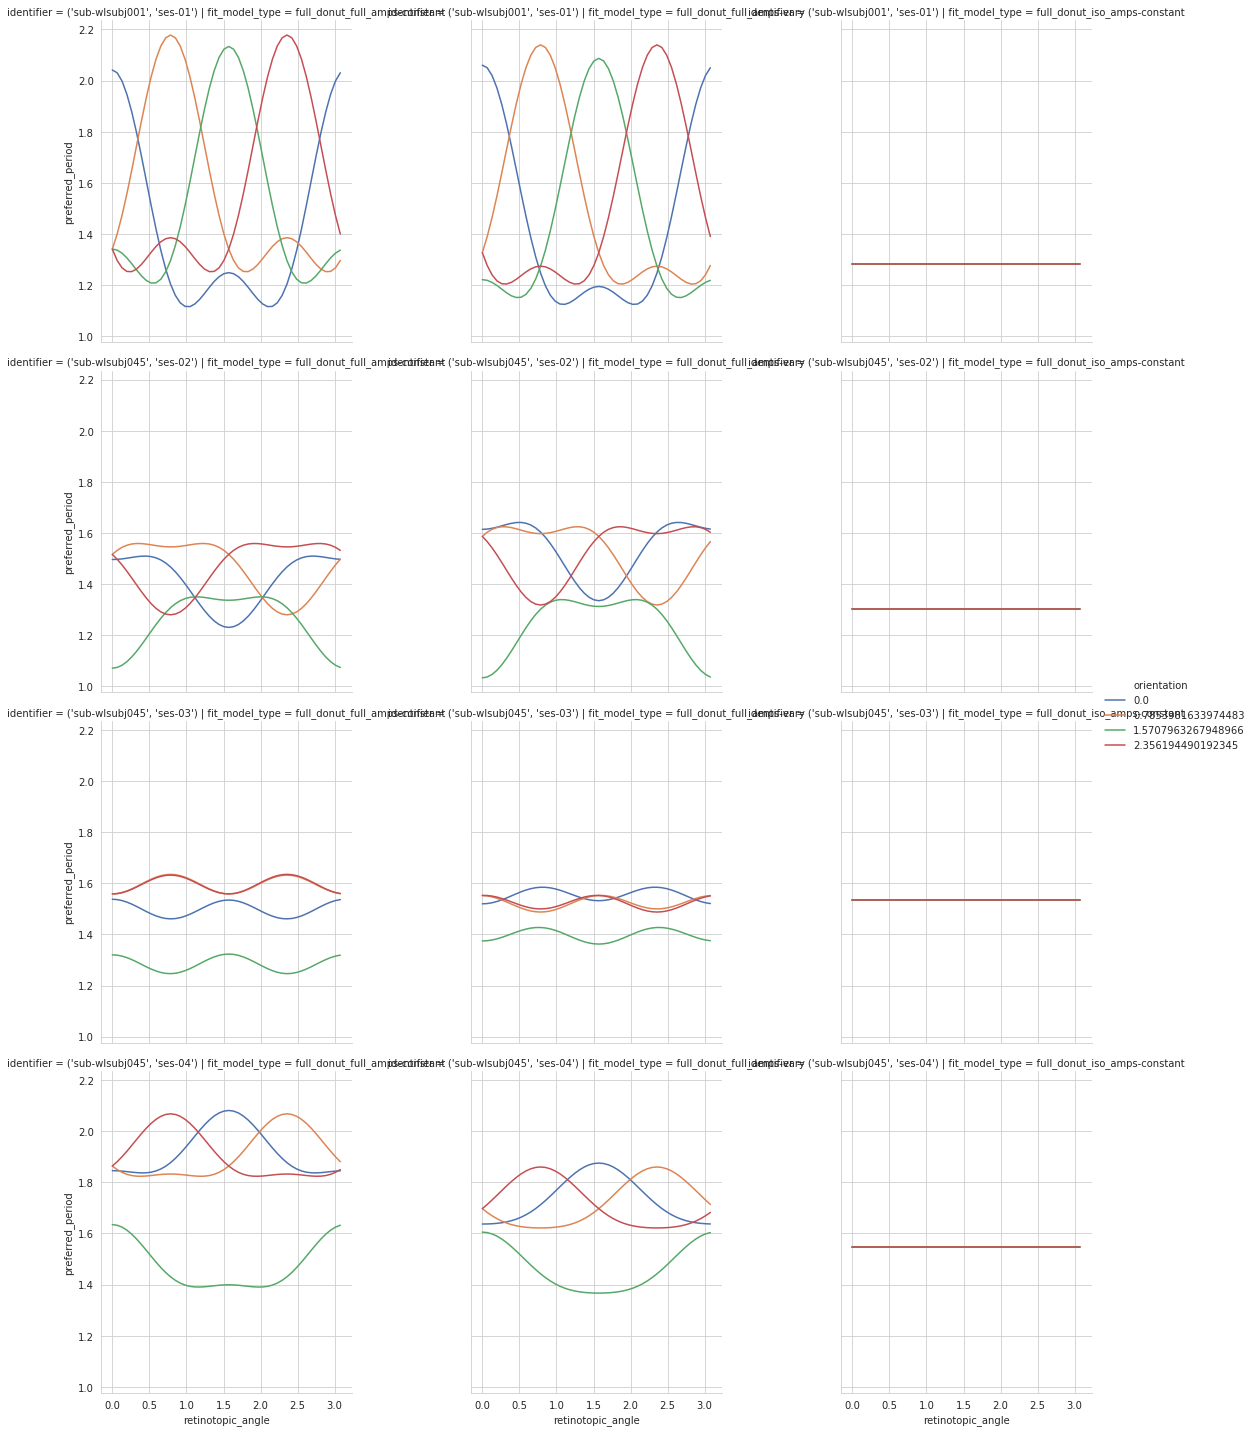

In [97]:
g = sns.relplot('retinotopic_angle', 'preferred_period', 'orientation', data=features[(features.eccentricity==features.eccentricity.unique()[5])&(features.orientation.isin(example_oris))&(features.fit_model_type.isin(['full_donut_iso_amps-constant', 'full_donut_full_amps-constant', 'full_donut_full_amps-vary']))],
                col='fit_model_type', row='identifier', kind='line', palette=sns.color_palette('deep', 4))

/home/billbrod/miniconda3/envs/sfp/lib/python3.6/site-packages/matplotlib/tight_layout.py:231: UserWarning: tight_layout : falling back to Agg renderer
  warnings.warn("tight_layout : falling back to Agg renderer")


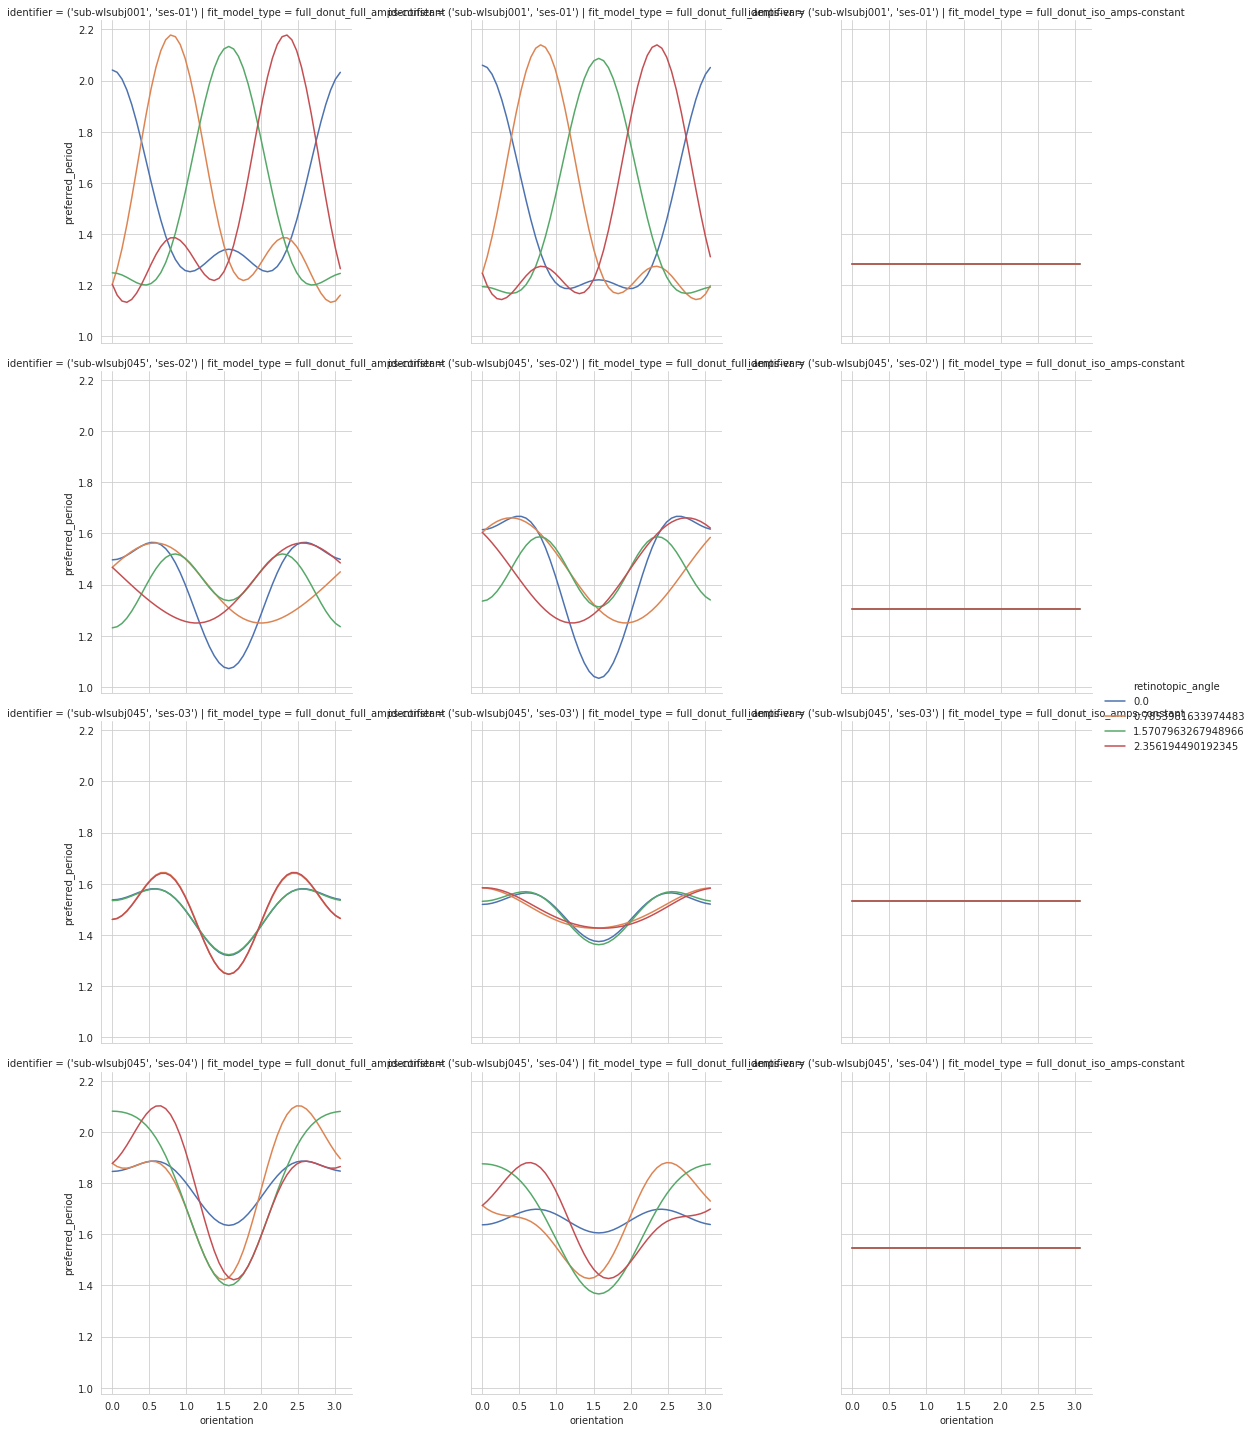

In [98]:
g = sns.relplot('orientation', 'preferred_period', 'retinotopic_angle', data=features[(features.eccentricity==features.eccentricity.unique()[5])&(features.retinotopic_angle.isin(example_oris))&(features.fit_model_type.isin(['full_donut_iso_amps-constant', 'full_donut_full_amps-constant', 'full_donut_full_amps-vary']))],
                col='fit_model_type', row='identifier', kind='line', palette=sns.color_palette('deep', 4))

## Other stuff

In [70]:
base_str = '/mnt/winawerlab/Projects/spatial_frequency_preferences/BIDS/derivatives/tuning_2d_model/stim_class/posterior/sub-wlsubj045/ses-02/sub-wlsubj045_ses-02_task-sfp_v1_e1-12_summary_b1_r1e-3_g0_cNone_'
full_constant,_,_ = sfp.analyze_model.load_single_model(base_str+'full_full_constant', False)
full_vary,_,_ = sfp.analyze_model.load_single_model(base_str+'full_full_vary', False)
iso_constant,_,_ = sfp.analyze_model.load_single_model(base_str+'iso_full_constant', False)
features = sfp.analyze_model.create_feature_df([full_constant,full_vary,iso_constant], orientation_range=(0, np.pi), orientation_n_steps=48, retinotopic_angle_n_steps=50)
example_oris = np.linspace(0, np.pi, num=4, endpoint=False)

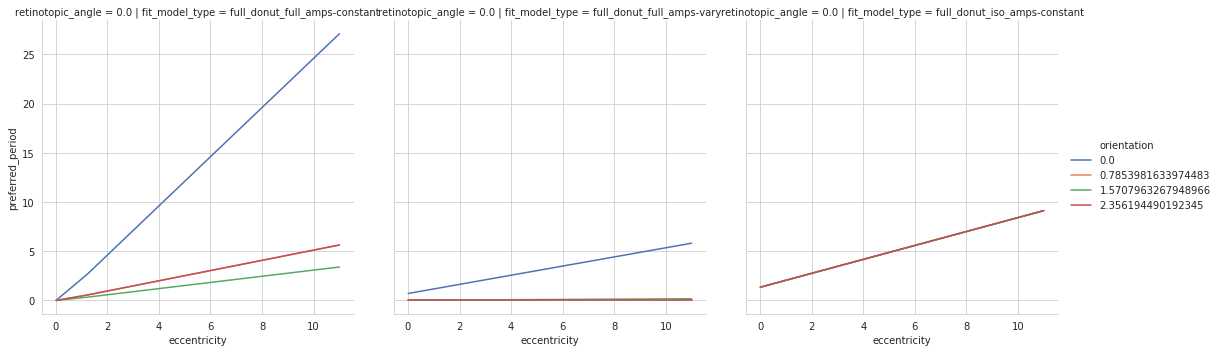

In [71]:
g = sns.relplot('eccentricity', 'preferred_period', 'orientation', data=features[(features.retinotopic_angle==0)&(features.orientation.isin(example_oris))],
                col='fit_model_type',
                row='retinotopic_angle', kind='line', palette=sns.color_palette('deep', 4))

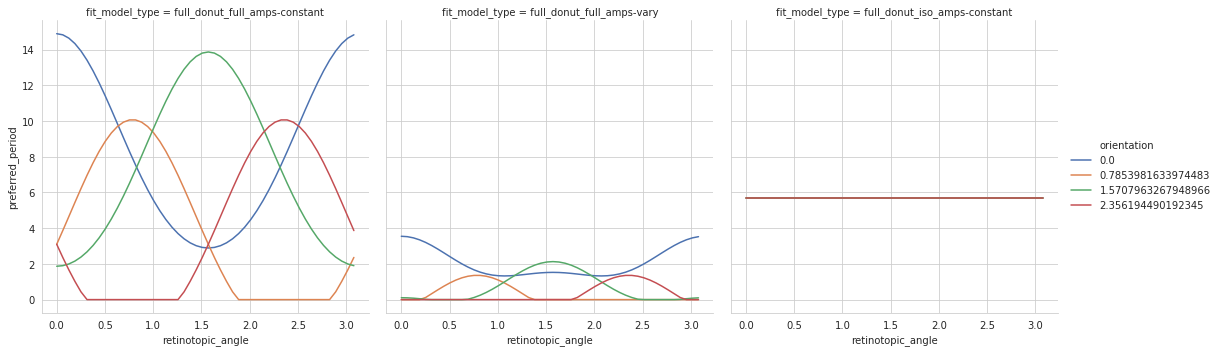

In [72]:
g = sns.relplot('retinotopic_angle', 'preferred_period', 'orientation',
                data=features[(features.eccentricity==features.eccentricity.unique()[5])&(features.orientation.isin(example_oris))],
                col='fit_model_type', kind='line', palette=sns.color_palette('deep', 4))

/home/billbrod/miniconda3/envs/sfp/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


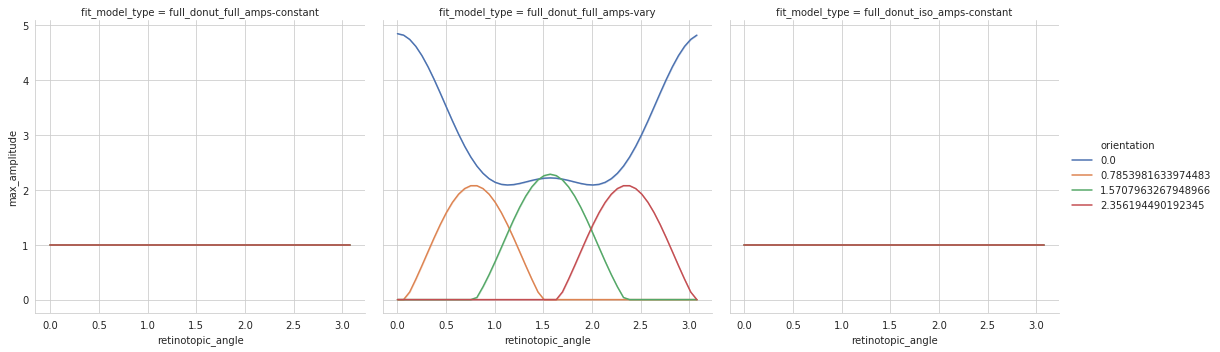

In [73]:
sns.relplot('retinotopic_angle', 'max_amplitude', 'orientation', data=features[(features.orientation.isin(example_oris))], col='fit_model_type',
            kind='line', palette=sns.color_palette('deep', 4))

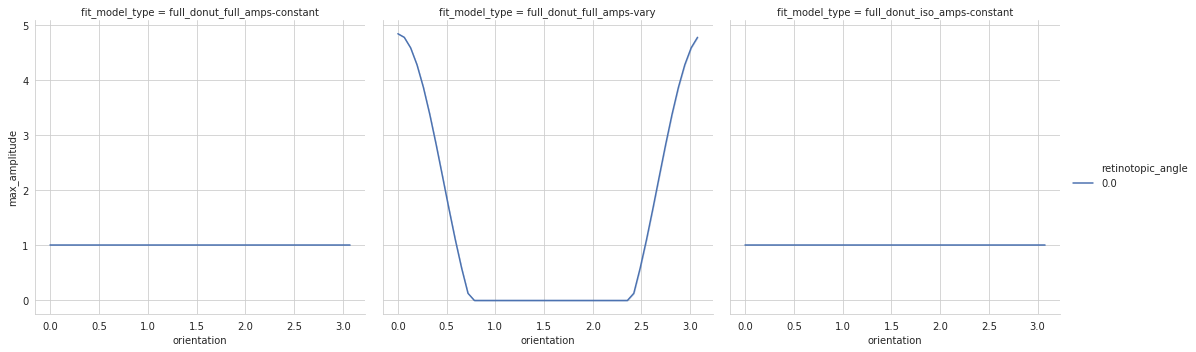

In [74]:
sns.relplot('orientation', 'max_amplitude', 'retinotopic_angle', data=features[features.retinotopic_angle==0],
            col='fit_model_type',
            kind='line', palette=sns.color_palette('deep', 1))

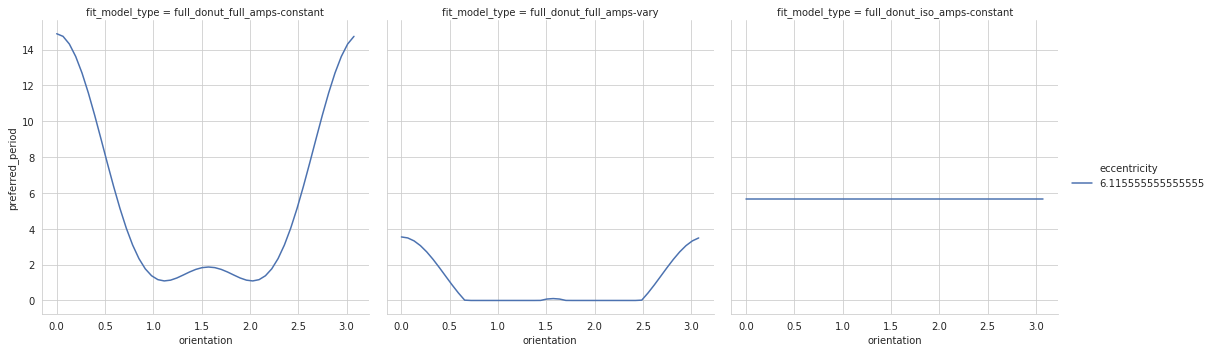

In [75]:
sns.relplot('orientation', 'preferred_period', 'eccentricity', data=features[(features.retinotopic_angle==0)&(features.eccentricity==features.eccentricity.unique()[5])],
            col='fit_model_type',
            kind='line', palette=sns.color_palette('deep', 1))

# Deprecated

The stuff below here doesn't run at the moment, but should be able to without too much of an issue

In [29]:
reduced_results = results_df.drop_duplicates(['fit_model_type', 'voxel', 'test_subset'])
reduced_results = reduced_results.groupby(['fit_model_type', 'voxel'])[['model_prediction_loss','model_prediction_correlation', 'eccen', 'angle', 'precision']].mean().reset_index()

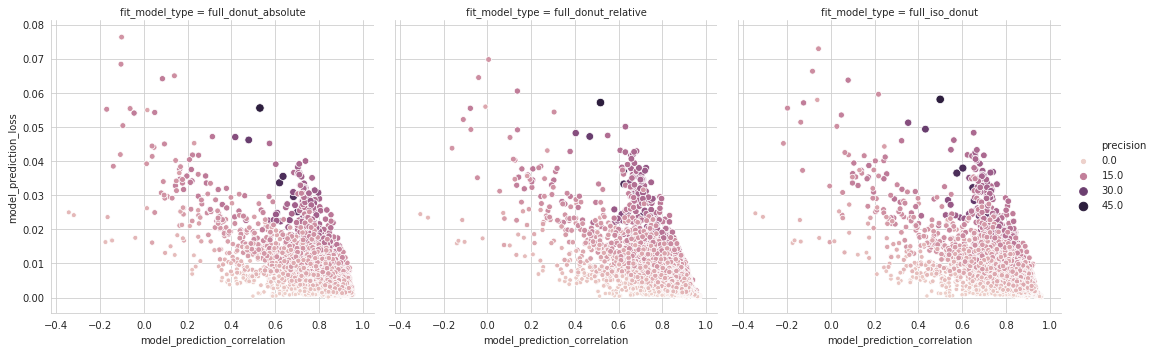

In [34]:
sns.relplot('model_prediction_correlation', 'model_prediction_loss', 'precision', 'precision', data=reduced_results, col='fit_model_type')

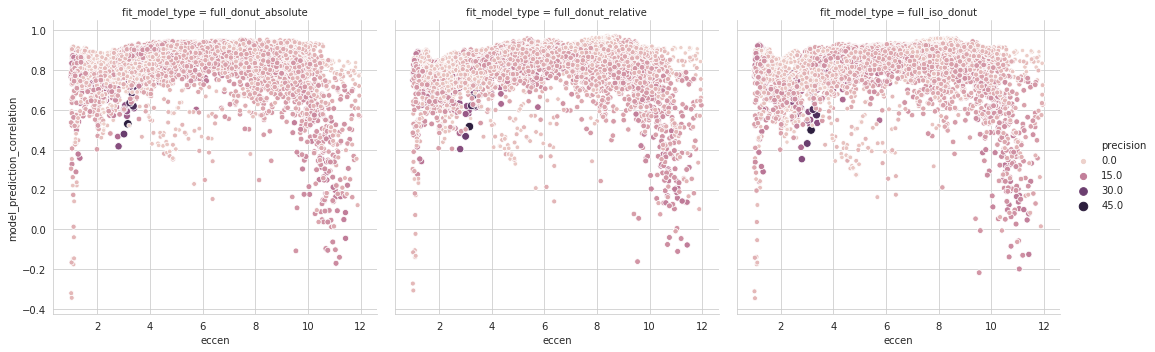

In [37]:
sns.relplot('eccen', 'model_prediction_correlation', 'precision', 'precision', data=reduced_results, col='fit_model_type')

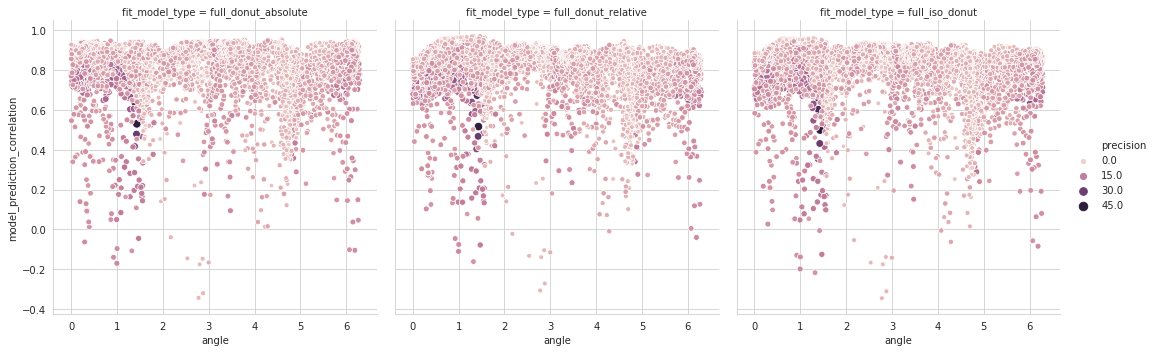

In [41]:
sns.relplot('angle', 'model_prediction_correlation', 'precision', 'precision', data=reduced_results, col='fit_model_type')

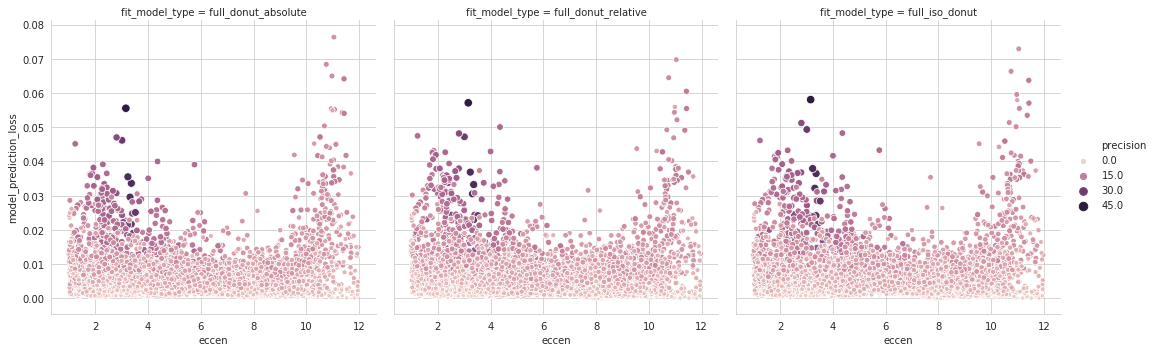

In [38]:
sns.relplot('eccen', 'model_prediction_loss', 'precision', 'precision', data=reduced_results, col='fit_model_type')

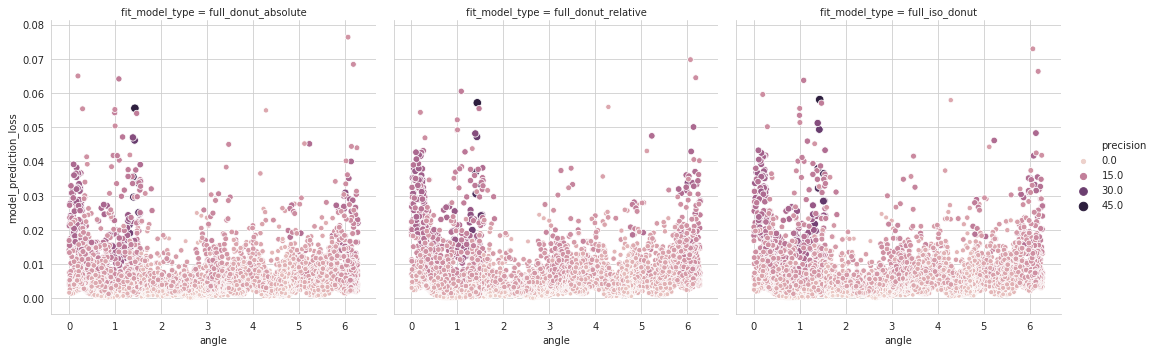

In [42]:
sns.relplot('angle', 'model_prediction_loss', 'precision', 'precision', data=reduced_results, col='fit_model_type')

In [88]:
a = m.sf_ecc_slope.detach().numpy()
b = m.sf_ecc_intercept.detach().numpy()
s = m.sigma.detach().numpy()
eccen = np.linspace(0.01, 10, 120)
period = np.linspace(.01, 2, 100)
resps = np.zeros((100, 120))
for i, e in enumerate(eccen):
    r = m.evaluate(1./period, np.zeros_like(period), e*np.ones_like(period), np.zeros_like(period)).detach()
    resps[:,i] = r

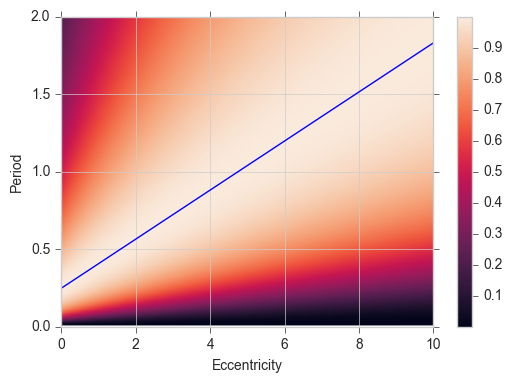

In [90]:
ax = plt.imshow(resps, origin='lower', extent=(eccen.min(), eccen.max(), period.min(), period.max()), aspect='auto')
plt.ylabel('Period')
plt.xlabel('Eccentricity')
plt.plot(eccen,(a*eccen+b))
#plt.plot(eccen,(a/(1+s)*eccen+b), 'b--')
y = (1+s)*a*eccen+b
#plt.plot(eccen[y<period.max()],y[y<period.max()], 'b--')
plt.colorbar()
plt.savefig('new_results.pdf')

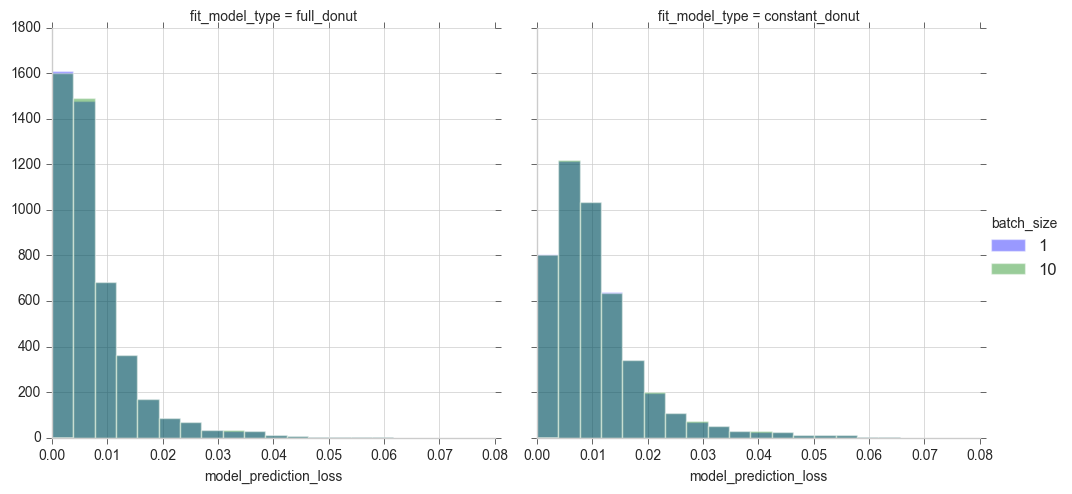

In [7]:
g = sns.FacetGrid(results_df.drop_duplicates(['voxel', 'fit_model_type', 'batch_size']), col='fit_model_type',hue='batch_size', height=5)
g.map(sns.distplot, 'model_prediction_loss', kde=False, bins=np.linspace(0, results_df.model_prediction_loss.max(), 20))
g.add_legend()

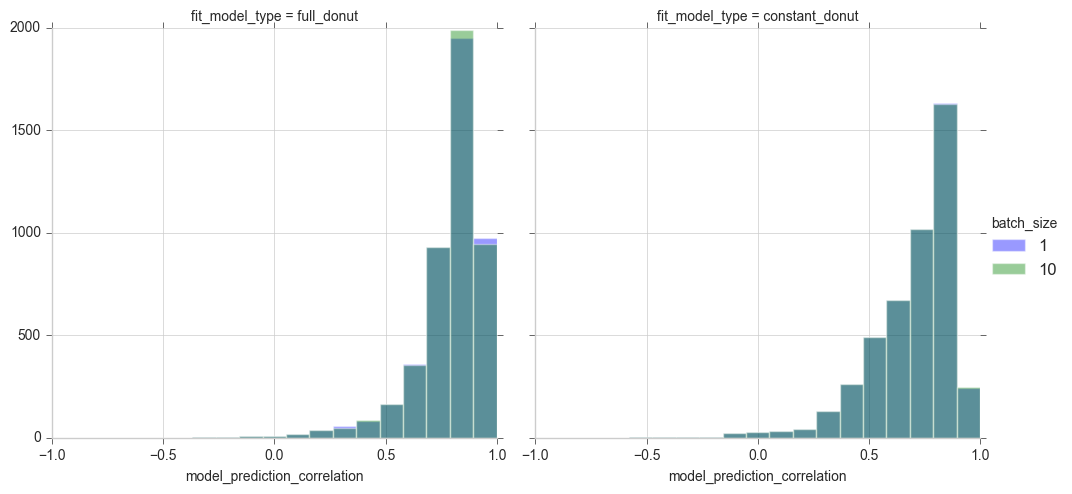

In [4]:
g = sns.FacetGrid(results_df.drop_duplicates(['voxel', 'fit_model_type', 'batch_size']), col='fit_model_type', hue='batch_size', height=5)
g.map(sns.distplot, 'model_prediction_correlation', kde=False, bins=np.linspace(-1, 1, 20))
g.add_legend()

In [9]:
voxel_df = results_df[results_df.voxel == results_df.voxel.unique()[0]]

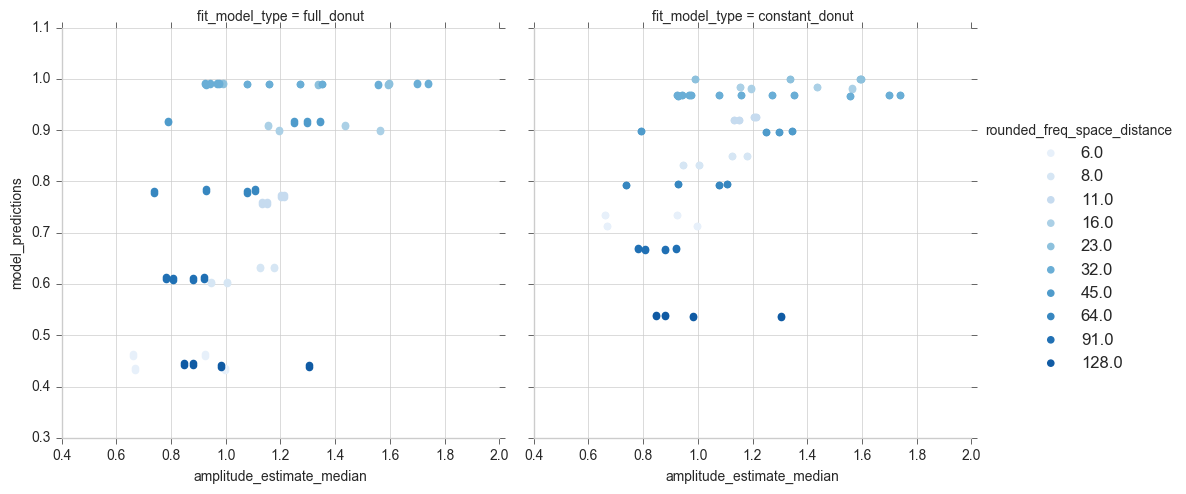

In [22]:
g = sns.FacetGrid(voxel_df, col='fit_model_type', hue='rounded_freq_space_distance',palette=sns.color_palette('Blues', 11), size=5)
g.map(plt.scatter, 'amplitude_estimate_median', 'model_predictions')
g.add_legend()

In [39]:
best_voxels = results_df[(results_df.batch_size==10)&(results_df.fit_model_type=='full_donut')&(results_df.model_prediction_loss<.001)]
print(best_voxels.voxel.nunique())

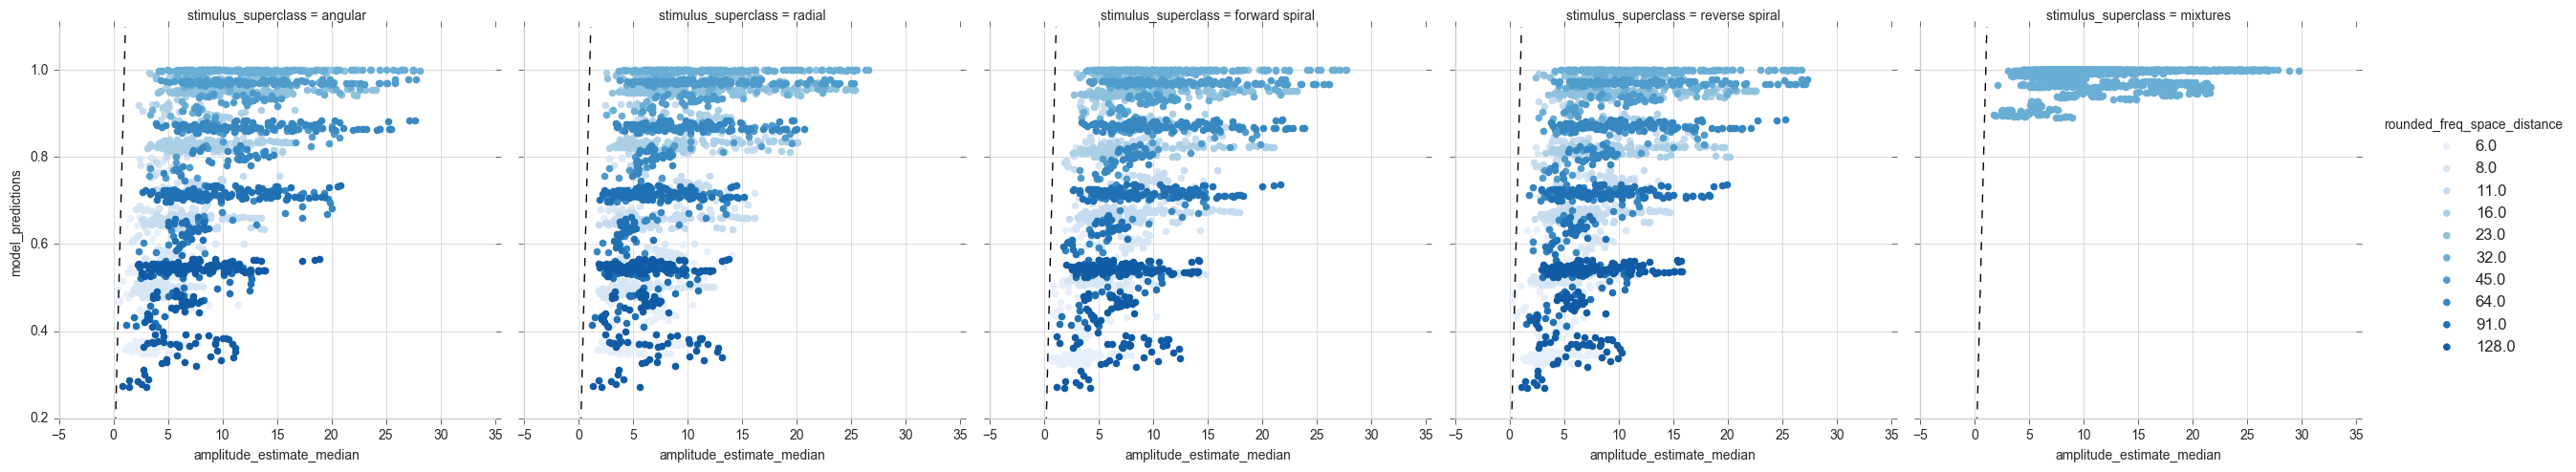

In [41]:
g = sns.FacetGrid(best_voxels, hue='rounded_freq_space_distance', col='stimulus_superclass', palette=sns.color_palette('Blues',11), size=5)
g.map(plt.scatter, 'amplitude_estimate_median', 'model_predictions')
xlim = g.axes.flatten()[0].get_xlim()
ylim = g.axes.flatten()[0].get_ylim()
for ax in g.axes.flatten():
    ax.plot(xlim, xlim, 'k--')
g.set(xlim=xlim, ylim=ylim)
g.add_legend()